In [1]:
# ============================================================
# KSWGD Global Parameters (Shared by DMPS and Koopman SDMD)
# ============================================================

# Iteration settings
n_iter_kswgd = 10000           # Total gradient descent iterations (increased for slower convergence)
h_kswgd = 0.02                 # Step size / learning rate (CRITICAL: smaller = less collapse)
record_interval = 100          # Record metrics every N steps

# Particle initialization
n_init_particles = 2000        # Number of particles to initialize (more = better coverage)

# Spectral method settings
n_skip = 1                     # Skip first eigenvalue (stationary mode)
eig_threshold = 0.001          # Eigenvalue threshold (backup, not used when fixed modes)
c_epsilon = 0.5                # Kernel bandwidth coefficient for adaptive epsilon calculation

# Fixed mode counts (set to None to use eig_threshold instead)
k_modes_dm_fixed = 480          # Fixed number of DMPS modes (after skipping n_skip)
k_modes_sdmd_fixed = 250        # Fixed number of Koopman(SDMD) modes (after skipping n_skip)

# Random seed (set to None for non-deterministic results)
random_seed = 2             # Random seed for reproducibility (None = random)

print("="*60)
print("KSWGD GLOBAL PARAMETERS")
print("="*60)
print(f"Initial particles:     {n_init_particles}")
print(f"Eigenvalue threshold:  {eig_threshold}")
print(f"Kernel bandwidth coef: {c_epsilon}")
print(f"Random seed:           {random_seed if random_seed is not None else 'None (random)'}")
print("="*60)

KSWGD GLOBAL PARAMETERS
Initial particles:     2000
Eigenvalue threshold:  0.001
Kernel bandwidth coef: 0.5
Random seed:           2


# Quadruple-Well Potential System: SDMD + KSWGD

## Objective
1. Define 2D quadruple-well potential system V(x,y) = (x^2-1)^2 + (y^2-1)^2
2. Compute corresponding Boltzmann stationary distribution $\pi(x) \propto \exp(-V(x))$
3. Learn Langevin generator using SDMD
4. Use KSWGD to transport particles from outside wells into the four potential wells

## Theoretical Background
- Langevin dynamics: $dX = -\nabla V(X)dt + \sqrt{2}dW$
- Stationary distribution: $\pi(x) \propto \exp(-V(x))$
- Four potential wells located at $(\pm 1, \pm 1)$
- Goal: Learn generator from data, transport particles to stationary distribution

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd, eig
import time
import torch
import subprocess

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================
# GPU Setup: Select the most free GPU at the very beginning
# This ensures all subsequent cells use the same GPU consistently
# ============================================================
def get_most_free_gpu():
    """Query nvidia-smi to find the GPU with the lowest utilization."""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=index,memory.used,memory.total,utilization.gpu', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        lines = result.stdout.strip().split('\n')
        best_gpu = 0
        best_score = float('inf')
        print("GPU Status:")
        for line in lines:
            parts = [p.strip() for p in line.split(',')]
            idx = int(parts[0])
            mem_used = float(parts[1])
            mem_total = float(parts[2])
            util = float(parts[3])
            mem_usage_pct = 100 * mem_used / mem_total
            score = util + mem_usage_pct
            print(f"  GPU-{idx}: Util={util:.0f}%, Mem={mem_used:.0f}/{mem_total:.0f} MiB ({mem_usage_pct:.1f}%)")
            if score < best_score:
                best_score = score
                best_gpu = idx
        print(f">>> Selected GPU-{best_gpu}")
        return best_gpu
    except Exception as e:
        print(f"Warning: Could not query GPU: {e}, defaulting to GPU-0")
        return 0

# Setup GPU device - THIS IS THE SINGLE SOURCE OF TRUTH FOR GPU SELECTION
if torch.cuda.is_available():
    best_gpu_idx = get_most_free_gpu()
    device_compute = torch.device(f'cuda:{best_gpu_idx}')
    device = str(device_compute)  # String version for compatibility
    print(f"✓ Using GPU-{best_gpu_idx}: {torch.cuda.get_device_name(best_gpu_idx)}")
    print(f"  device_compute = {device_compute}")
    print(f"  device = '{device}'")
else:
    device_compute = torch.device('cpu')
    device = 'cpu'
    best_gpu_idx = -1
    print("⚠ GPU not available, using CPU")

print("\nLibraries imported successfully!")

GPU Status:
  GPU-0: Util=3%, Mem=2059/20475 MiB (10.1%)
>>> Selected GPU-0
✓ Using GPU-0: NVIDIA RTX 4000 SFF Ada Generation
  device_compute = cuda:0
  device = 'cuda:0'

Libraries imported successfully!


## Define Four-Well Potential Function

We define a 2D four-well potential:
$$V(x, y) = (x^2 - 1)^2 + (y^2 - 1)^2$$

This potential has four local minima:
- Well 1: (x, y) $\approx$ (-1, -1)
- Well 2: (x, y) $\approx$ (1, -1)
- Well 3: (x, y) $\approx$ (-1, 1)
- Well 4: (x, y) $\approx$ (1, 1)
- Central saddle point: (0, 0)

In [3]:
class FourWellPotential:
    """
    2D Four-Well Potential System
    
    Potential function: V(x, y) = a*(x^2 - 1)^2 + b*(y^2 - 1)^2
    
    This creates four potential wells at approximately (\pm 1, \pm 1)
    
    Parameters:
        a: Controls double-well depth in x-direction (default 1.0)
        b: Controls double-well depth in y-direction (default 1.0)
        temperature: Temperature parameter (default 1.0), affects Boltzmann distribution width
    """
    
    def __init__(self, a=1.0, b=1.0, temperature=1.0):
        self.a = a
        self.b = b
        self.T = temperature  # Temperature (kT in units where k_B = 1)
        self._Z = None  # Partition function cache
        
    def V(self, x, y=None):
        """
        Compute potential energy
        
        Parameters:
            x: If y is None, x is array of shape (n, 2)
               Otherwise x is x-coordinate, y is y-coordinate
        Returns:
            Potential energy value(s)
        """
        if y is None:
            # x is (n, 2) array
            x_coord = x[:, 0] if x.ndim > 1 else x[0]
            y_coord = x[:, 1] if x.ndim > 1 else x[1]
        else:
            x_coord = x
            y_coord = y
            
        return self.a * (x_coord**2 - 1)**2 + self.b * (y_coord**2 - 1)**2
    
    def grad_V(self, X):
        """
        Compute potential gradient \nabla V(x, y)
        
        Parameters:
            X: Array of shape (n, 2), each row is a point (x, y)
        Returns:
            Gradient array of shape (n, 2)
        """
        x = X[:, 0]
        y = X[:, 1]
        
        # \partial V / \partial x = 4*a*x*(x^2 - 1)
        dV_dx = 4 * self.a * x * (x**2 - 1)
        
        # \partial V / \partial y = 4*b*y*(y^2 - 1)
        dV_dy = 4 * self.b * y * (y**2 - 1)
        
        return np.stack([dV_dx, dV_dy], axis=1)
    
    def stationary_density(self, x, y=None, x_range=(-3, 3), y_range=(-3, 3), n_grid=500):
        """
        Compute normalized Boltzmann stationary distribution \pi(x) = exp(-V(x)/T) / Z
        
        Parameters:
            x, y: Coordinates (can be scalar, array, or grid)
            x_range, y_range: Range for numerical integration to compute Z
            n_grid: Grid size for numerical integration
            
        Returns:
            Normalized density values
        """
        # Compute unnormalized density
        V_val = self.V(x, y)
        unnormalized_density = np.exp(-V_val / self.T)
        
        # Compute partition function Z if not cached
        if self._Z is None:
            x_int = np.linspace(x_range[0], x_range[1], n_grid)
            y_int = np.linspace(y_range[0], y_range[1], n_grid)
            dx = (x_range[1] - x_range[0]) / n_grid
            dy = (y_range[1] - y_range[0]) / n_grid
            X_int, Y_int = np.meshgrid(x_int, y_int)
            V_int = self.V(X_int, Y_int)
            self._Z = np.sum(np.exp(-V_int / self.T)) * dx * dy
        
        return unnormalized_density / self._Z

# Create four-well system instance
potential = FourWellPotential(a=1.0, b=1.0, temperature=1)

print("Four-well potential system created!")
print(f"Parameters: a={potential.a}, b={potential.b}, T={potential.T}")
print(f"Energy minima locations: (+/-1, +/-1)")
print(f"Minimum energy value: V(1, 1) = {potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Saddle point value: V(0, 0) = {potential.V(np.array([[0.0, 0.0]]))[0]:.4f}")

Four-well potential system created!
Parameters: a=1.0, b=1.0, T=1
Energy minima locations: (+/-1, +/-1)
Minimum energy value: V(1, 1) = 0.0000
Saddle point value: V(0, 0) = 2.0000


## Visualize Potential Landscape and Stationary Distribution

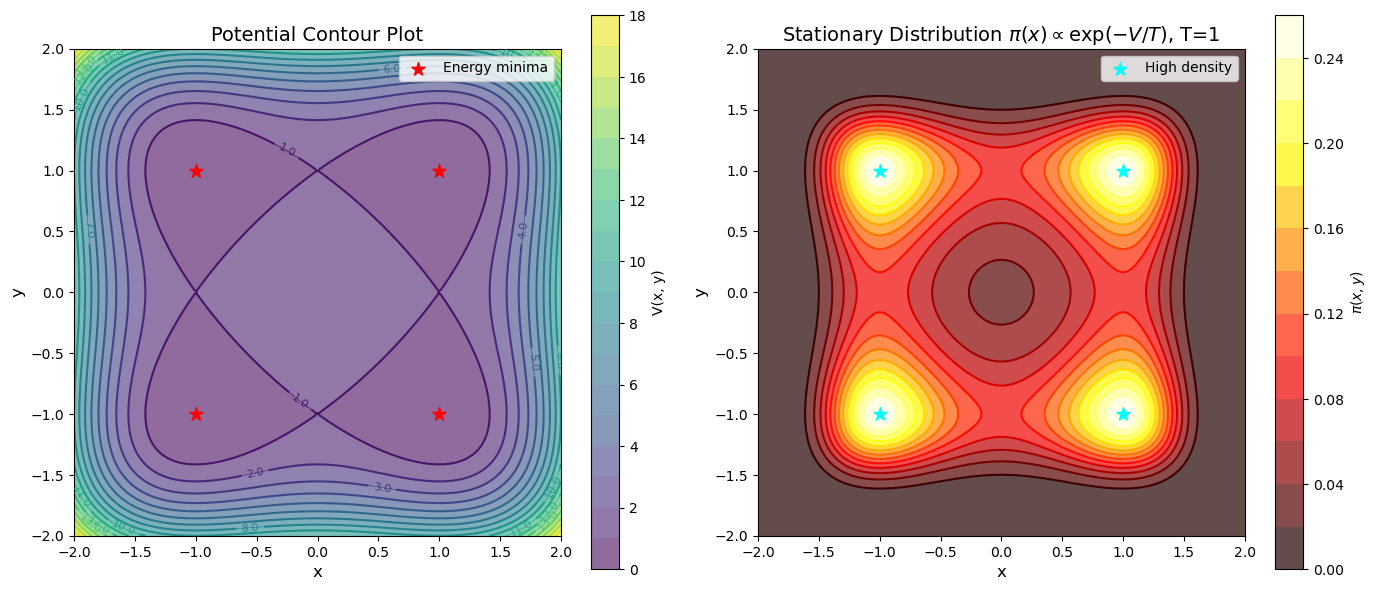


Potential Analysis:
Energy minima: V(+/-1, +/-1) = 0.0000
Central saddle: V(0, 0) = 2.0000
Side saddles: V(+/-1, 0) = 1.0000
Energy difference: DeltaV = 2.0000
Temperature parameter: T = 1

Stationary distribution concentrates around four energy minima!


In [4]:
# Create grid for visualization
x_range = np.linspace(-2, 2, 200)
y_range = np.linspace(-2, 2, 200)
X_grid, Y_grid = np.meshgrid(x_range, y_range)

# Compute potential and density
V_grid = potential.V(X_grid, Y_grid)
density_grid = potential.stationary_density(X_grid, Y_grid)

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ========== Subplot 1: Potential Contour Plot ==========
ax1 = axes[0]
contour = ax1.contour(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', linewidths=1.5)
contourf = ax1.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.6)
ax1.clabel(contour, inline=True, fontsize=8, fmt='%.1f')
ax1.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='red', s=100, marker='*', 
           label='Energy minima', zorder=10)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title('Potential Contour Plot', fontsize=14)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right')
fig.colorbar(contourf, ax=ax1, label='V(x, y)')

# ========== Subplot 2: Boltzmann Stationary Distribution ==========
ax2 = axes[1]
contour_density = ax2.contour(X_grid, Y_grid, density_grid, levels=15, 
                              cmap='hot', linewidths=1.5)
contourf_density = ax2.contourf(X_grid, Y_grid, density_grid, levels=15, 
                                cmap='hot', alpha=0.7)
ax2.scatter([-1, -1, 1, 1], [-1, 1, -1, 1], color='cyan', s=100, marker='*', 
           label='High density', zorder=10)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('y', fontsize=12)
ax2.set_title(f'Stationary Distribution $\\pi(x) \\propto \\exp(-V/T)$, T={potential.T}', 
             fontsize=14)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right')
fig.colorbar(contourf_density, ax=ax2, label='$\\pi(x, y)$')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Potential Analysis:")
print("="*60)
print(f"Energy minima: V(+/-1, +/-1) = {potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Central saddle: V(0, 0) = {potential.V(np.array([[0.0, 0.0]]))[0]:.4f}")
print(f"Side saddles: V(+/-1, 0) = {potential.V(np.array([[1.0, 0.0]]))[0]:.4f}")
print(f"Energy difference: DeltaV = {potential.V(np.array([[0.0, 0.0]]))[0] - potential.V(np.array([[1.0, 1.0]]))[0]:.4f}")
print(f"Temperature parameter: T = {potential.T}")
print(f"\nStationary distribution concentrates around four energy minima!")
print("="*60)

## Verify Stationary Distribution Normalization

Check that the stationary distribution is properly normalized ($\int \pi(x) dx = 1$)

In [5]:
# Verify normalization of stationary distribution
# Numerically integrate pi(x) over the entire domain

# Use a fine grid for accurate integration
x_int = np.linspace(-3, 3, 300)
y_int = np.linspace(-3, 3, 300)
X_int, Y_int = np.meshgrid(x_int, y_int)
dx = x_int[1] - x_int[0]
dy = y_int[1] - y_int[0]

# Compute density on integration grid
density_int = potential.stationary_density(X_int, Y_int)

# Numerical integration using trapezoidal rule
integral = np.sum(density_int) * dx * dy

print("="*60)
print("Normalization Verification:")
print("="*60)
print(f"Numerical integral of pi(x) over domain: {integral:.6f}")
print(f"Expected value: 1.0")
print(f"Relative error: {abs(integral - 1.0):.2e}")
print("="*60)

if abs(integral - 1.0) < 0.01:
    print("Check: Distribution is properly normalized!")
else:
    print("Warning: Distribution normalization may be inaccurate")
    print("  (This could be due to finite integration domain)")
print("="*60)

Normalization Verification:
Numerical integral of pi(x) over domain: 1.004012
Expected value: 1.0
Relative error: 4.01e-03
Check: Distribution is properly normalized!


## Generate Training Data: (X_tar, X_tar_next)

Sample X_tar from stationary distribution $\pi(x)$, then evolve to X_tar_next using Langevin dynamics:
$$dX = -\nabla V(X)dt + \sqrt{2}dW$$

In [6]:
# ============================================================
# Step 1: Generate Time Series Trajectory using Langevin Dynamics
# ============================================================

def generate_langevin_trajectory(potential, n_samples=2500, dt=0.1, n_substeps=10, burnin=1000):
    """
    Generate a single long trajectory from Langevin dynamics
    
    SDE: dX = -âˆ‡V(X)dt + âˆš(2)dW
    
    Parameters:
        potential: FourWellPotential instance
        n_samples: Number of trajectory points to generate
        dt: Time step between saved points
        n_substeps: Number of sub-steps for numerical stability per dt
        burnin: Number of initial steps to discard (thermalization)
    
    Returns:
        trajectory: Array of shape (n_samples, 2) - consecutive time series points
    """
    # Initialize at a random position
    X_curr = np.random.randn(2) * 0.5
    
    trajectory = []
    n_total = burnin + n_samples
    dt_sub = dt / n_substeps
    
    print(f"Generating Langevin trajectory:")
    print(f"  - Total time steps: {n_total}")
    print(f"  - Burnin steps: {burnin}")
    print(f"  - Trajectory length: {n_samples}")
    print(f"  - dt = {dt}, sub-steps = {n_substeps}, dt_sub = {dt_sub:.6f}")
    
    for i in range(n_total):
        # Evolve for one time step (with n_substeps)
        for _ in range(n_substeps):
            # Drift term: -âˆ‡V(X)
            grad_V = potential.grad_V(X_curr.reshape(1, -1))
            drift = -grad_V[0]
            
            # Diffusion term: âˆš(2 * dt_sub) * Gaussian noise
            noise = np.sqrt(2.0 * dt_sub) * np.random.randn(2)
            
            # Euler-Maruyama update
            X_curr = X_curr + drift * dt_sub + noise
        
        # Store trajectory point after burnin
        if i >= burnin:
            trajectory.append(X_curr.copy())
        
        # Progress indicator
        if (i + 1) % 500 == 0:
            print(f"  Progress: {i+1}/{n_total} steps", end='\r')
    
    print(f"\n  Trajectory generation complete!")
    return np.array(trajectory)

# Generate trajectory data
n_samples = 10000
dt = 0.01  # Time step between consecutive points
n_substeps = 10  # Numerical stability
burnin = 1000  # Thermalization period

print("="*60)
print("Generating X_tar as a time series trajectory...")
print("="*60)
X_tar = generate_langevin_trajectory(potential, n_samples=n_samples, dt=dt, 
                                     n_substeps=n_substeps, burnin=burnin)
print(f"\nX_tar shape: {X_tar.shape}")
print(f"X_tar range: x âˆˆ [{X_tar[:, 0].min():.2f}, {X_tar[:, 0].max():.2f}], "
      f"y âˆˆ [{X_tar[:, 1].min():.2f}, {X_tar[:, 1].max():.2f}]")
print(f"\nâœ“ Data type: CONSECUTIVE TIME SERIES (not i.i.d. samples)")
print(f"  X_tar[i] â†’ X_tar[i+1] are temporally correlated")
print("="*60)

Generating X_tar as a time series trajectory...
Generating Langevin trajectory:
  - Total time steps: 11000
  - Burnin steps: 1000
  - Trajectory length: 10000
  - dt = 0.01, sub-steps = 10, dt_sub = 0.001000
  Progress: 11000/11000 steps
  Trajectory generation complete!

X_tar shape: (10000, 2)
X_tar range: x âˆˆ [-1.74, 1.78], y âˆˆ [-1.81, 1.81]

âœ“ Data type: CONSECUTIVE TIME SERIES (not i.i.d. samples)
  X_tar[i] â†’ X_tar[i+1] are temporally correlated


In [7]:
# ============================================================
# Step 2: Create X_tar_next from consecutive trajectory points
# ============================================================

print("="*60)
print("Creating training pairs (X_tar, X_tar_next) from trajectory...")
print("="*60)
print(f"Method: Consecutive time series points")
print(f"  X_tar[i] at time t_i")
print(f"  X_tar_next[i] at time t_(i+1) = t_i + dt")

# Simply shift the trajectory by one time step
X_tar_next = X_tar[1:].copy()  # Points from t=1 to t=2500
X_tar = X_tar[:-1].copy()      # Points from t=0 to t=2499

print(f"\nX_tar shape: {X_tar.shape}")
print(f"X_tar_next shape: {X_tar_next.shape}")
print(f"\nTraining pairs: {X_tar.shape[0]}")
print(f"Time lag: dt = {dt}")
print(f"\nâœ“ Each pair (X_tar[i], X_tar_next[i]) represents:")
print(f"  one step evolution under Langevin dynamics")
print("="*60)

Creating training pairs (X_tar, X_tar_next) from trajectory...
Method: Consecutive time series points
  X_tar[i] at time t_i
  X_tar_next[i] at time t_(i+1) = t_i + dt

X_tar shape: (9999, 2)
X_tar_next shape: (9999, 2)

Training pairs: 9999
Time lag: dt = 0.01

âœ“ Each pair (X_tar[i], X_tar_next[i]) represents:
  one step evolution under Langevin dynamics


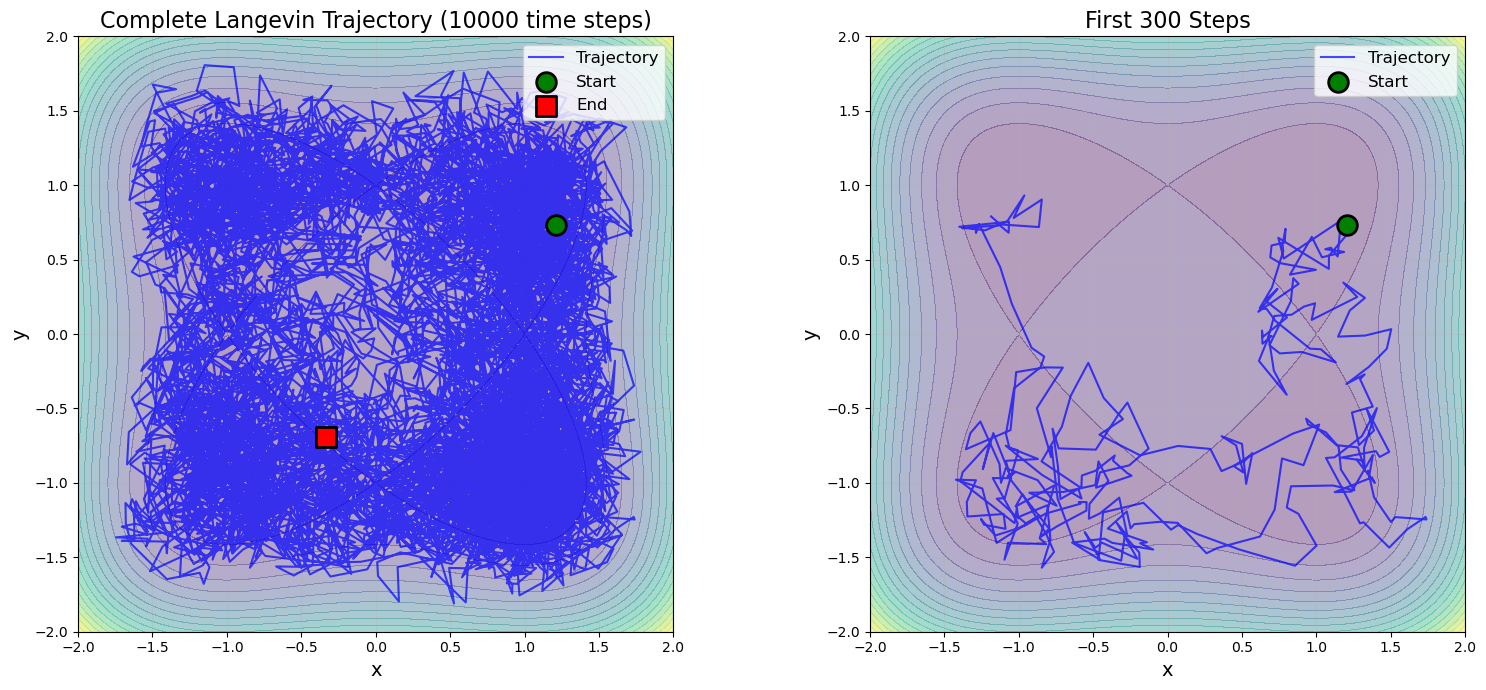


Time Series Trajectory
Total trajectory length: 10000 time steps
Time interval: dt = 0.01
Total simulation time: 100.0 time units


In [8]:
# ============================================================
# Visualize Time Series Trajectory
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ========== Subplot 1: Complete Trajectory ==========
ax1 = axes[0]

# Plot potential contour as background
contourf1 = ax1.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.4)

# Plot the trajectory as a simple blue line
ax1.plot(X_tar[:, 0], X_tar[:, 1], 'b-', linewidth=1.5, alpha=0.7, label='Trajectory')

# Mark start and end points
ax1.scatter(X_tar[0, 0], X_tar[0, 1], c='green', s=200, marker='o', 
           edgecolors='black', linewidth=2, label='Start', zorder=10)
ax1.scatter(X_tar[-1, 0], X_tar[-1, 1], c='red', s=200, marker='s', 
           edgecolors='black', linewidth=2, label='End', zorder=10)

ax1.set_xlabel('x', fontsize=14)
ax1.set_ylabel('y', fontsize=14)
ax1.set_title(f'Complete Langevin Trajectory ({len(X_tar)+1} time steps)', fontsize=16)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.legend(loc='upper right', fontsize=12)
ax1.grid(True, alpha=0.3)

# ========== Subplot 2: First 300 Steps ==========
ax2 = axes[1]
n_zoom = min(300, len(X_tar))

# Plot potential contour as background
contourf2 = ax2.contourf(X_grid, Y_grid, V_grid, levels=20, cmap='viridis', alpha=0.4)

# Plot the trajectory as a simple blue line (first 300 steps)
ax2.plot(X_tar[:n_zoom, 0], X_tar[:n_zoom, 1], 'b-', linewidth=1.5, alpha=0.7, label='Trajectory')

# Mark start point only
ax2.scatter(X_tar[0, 0], X_tar[0, 1], c='green', s=200, marker='o', 
           edgecolors='black', linewidth=2, label='Start', zorder=10)

ax2.set_xlabel('x', fontsize=14)
ax2.set_ylabel('y', fontsize=14)
ax2.set_title(f'First {n_zoom} Steps', fontsize=16)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Time Series Trajectory")
print("="*60)
print(f"Total trajectory length: {len(X_tar)+1} time steps")
print(f"Time interval: dt = {dt}")
print(f"Total simulation time: {len(X_tar) * dt:.1f} time units")
print("="*60)

In [9]:
# # ============================================================
# # Polynomial EDMD: Extended Dynamic Mode Decomposition
# # ============================================================

# # Preconditions
# if 'X_tar' not in globals() or 'X_tar_next' not in globals():
#     raise RuntimeError('X_tar and X_tar_next must be computed before running EDMD (polynomial).')

# n = X_tar.shape[0]

# # Step 1: Build polynomial basis functions
# degree = 4

# def monomial_exponents_2d(deg: int):
#     exps = []
#     for total in range(deg + 1):
#         for i in range(total + 1):
#             exps.append((i, total - i))
#     return exps

# exps = monomial_exponents_2d(degree)
# m_dict = len(exps)

# # Optional feature scaling for numerical stability
# Z_all = np.vstack([X_tar, X_tar_next])
# scale = 1.0  # No scaling for this example
# X0 = X_tar / scale
# Y0 = X_tar_next / scale

# # Feature map Î¦(X)
# def phi_poly(X: np.ndarray) -> np.ndarray:
#     N = X.shape[0]
#     Phi = np.empty((N, m_dict), dtype=float)
#     x = X[:, 0]
#     y = X[:, 1]
#     for k, (i, j) in enumerate(exps):
#         if i == 0 and j == 0:
#             Phi[:, k] = 1.0
#         elif i == 0:
#             Phi[:, k] = y ** j
#         elif j == 0:
#             Phi[:, k] = x ** i
#         else:
#             Phi[:, k] = (x ** i) * (y ** j)
#     return Phi

# Phi = phi_poly(X0)
# Phi_next = phi_poly(Y0)
# N = Phi.shape[0]

# # Step 2: Build EDMD matrices
# G_edmd = (Phi.T @ Phi) / N
# A_edmd = (Phi.T @ Phi_next) / N

# # Step 3: Compute Koopman operator
# reg = 1e-10
# I = np.eye(G_edmd.shape[0])
# K_edmd = np.linalg.solve(G_edmd + reg * I, A_edmd)

# # Step 4: Compute eigenvalues
# eigenvalues_edmd = np.linalg.eigvals(K_edmd)

# # Step 5: Construct generator eigenvalues and inverse weights
# # Extract real part of eigenvalues (ignore imaginary part)
# lambda_ns_edmd = eigenvalues_edmd.real

# # Construct generator eigenvalues: Î»_gen = (Î»_K - 1) / dt
# lambda_gen_edmd = (lambda_ns_edmd - 1.0) / dt

# # Build inverse generator weights (for KSWGD)
# tol_edmd = 1e-6
# lambda_ns_inv_edmd = np.zeros_like(lambda_ns_edmd)
# mask_edmd = lambda_ns_edmd >= tol_edmd
# lambda_ns_inv_edmd[mask_edmd] = 1.0 / (lambda_ns_edmd[mask_edmd] + 0.001)

# # Store results for KSWGD
# eigvals_K_edmd = lambda_ns_edmd.copy()
# lambda_gen_full_edmd = lambda_gen_edmd.copy()

# # ============================================================
# # Visualization: Eigenvalues on Unit Circle
# # ============================================================

# fig, ax = plt.subplots(figsize=(5, 5))

# # Plot unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# # Plot eigenvalues
# ax.scatter(eigenvalues_edmd.real, eigenvalues_edmd.imag, c='red', s=50, marker='o', 
#            edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# # Set equal aspect ratio and labels
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
# ax.set_xlabel('Real', fontsize=12)
# ax.set_ylabel('Imaginary', fontsize=12)
# ax.set_title('Polynomial EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
# ax.legend(fontsize=10)

# plt.tight_layout()
# plt.show()

# print(f"Number of eigenvalues: {len(eigenvalues_edmd)}")
# print(f"Max magnitude: {np.max(np.abs(eigenvalues_edmd)):.4f}")
# print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_edmd) > 1)}")

# # Sort eigenvalues by real part (descending order)
# sorted_real_edmd = np.sort(eigenvalues_edmd.real)[::-1]

# print("\n" + "="*50)
# print("Eigenvalues (Real part, sorted from large to small):")
# print("="*50)
# for i, real_part in enumerate(sorted_real_edmd):
#     print(f"{i+1:3d}. {real_part:+.6f}")

TRAINING DATA DISTRIBUTION IN 4 WELLS
Well 1 (-1,-1)      :   683 samples (  6.8%)
Well 2 (-1,+1)      :   650 samples (  6.5%)
Well 3 (+1,-1)      :  1773 samples ( 17.7%)
Well 4 (+1,+1)      :   876 samples (  8.8%)
----------------------------------------------------------------------
Total in wells      :  3982 samples ( 39.8%)
Outside wells       :  6017 samples ( 60.2%)
Total samples       :  9999


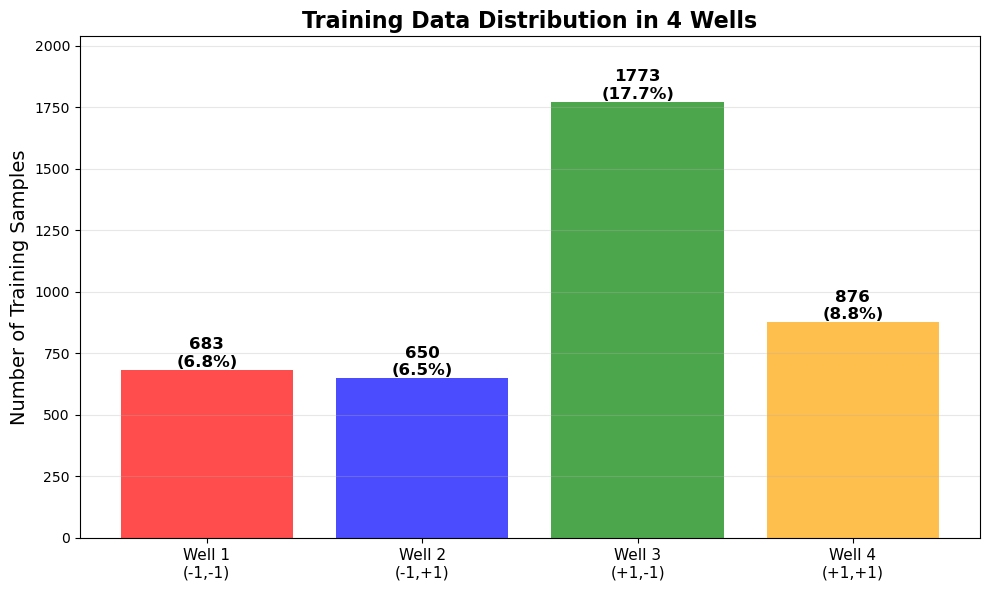


⚠️  IMBALANCE ANALYSIS:
   Max samples in one well: 1773
   Min samples in one well: 650
   Imbalance ratio: 2.73x

🟡 CAUTION: Moderate imbalance detected (ratio > 1.5x)
   Some wells may attract fewer particles.


In [10]:
# ============================================================
# Diagnostic: Check Training Data Distribution Across 4 Wells
# ============================================================

well_centers = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
well_radius = 0.4
well_labels = ['Well 1 (-1,-1)', 'Well 2 (-1,+1)', 'Well 3 (+1,-1)', 'Well 4 (+1,+1)']

print("="*70)
print("TRAINING DATA DISTRIBUTION IN 4 WELLS")
print("="*70)

training_basin_counts = []
for i, (center, label) in enumerate(zip(well_centers, well_labels)):
    distances = np.linalg.norm(X_tar - center, axis=1)
    count = np.sum(distances <= well_radius)
    training_basin_counts.append(count)
    percentage = 100.0 * count / len(X_tar)
    print(f"{label:20s}: {count:5d} samples ({percentage:5.1f}%)")

total_in_wells = sum(training_basin_counts)
total_samples = len(X_tar)
outside_wells = total_samples - total_in_wells

print("-"*70)
print(f"{'Total in wells':20s}: {total_in_wells:5d} samples ({100.0*total_in_wells/total_samples:5.1f}%)")
print(f"{'Outside wells':20s}: {outside_wells:5d} samples ({100.0*outside_wells/total_samples:5.1f}%)")
print(f"{'Total samples':20s}: {total_samples:5d}")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
x_positions = np.arange(len(well_labels))
bars = ax.bar(x_positions, training_basin_counts, color=['red', 'blue', 'green', 'orange'], alpha=0.7)

for i, (bar, count) in enumerate(zip(bars, training_basin_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({100.0*count/total_samples:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# ax.set_xlabel('Well', fontsize=14)
ax.set_ylabel('Number of Training Samples', fontsize=14)
ax.set_title('Training Data Distribution in 4 Wells', fontsize=16, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels(['Well 1\n(-1,-1)', 'Well 2\n(-1,+1)', 'Well 3\n(+1,-1)', 'Well 4\n(+1,+1)'], fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(training_basin_counts) * 1.15)

plt.tight_layout()
plt.show()

# Check imbalance
max_count = max(training_basin_counts)
min_count = min(training_basin_counts)
imbalance_ratio = max_count / (min_count + 1e-10)

print(f"\n⚠️  IMBALANCE ANALYSIS:")
print(f"   Max samples in one well: {max_count}")
print(f"   Min samples in one well: {min_count}")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}x")

if imbalance_ratio > 3.0:
    print(f"\n🔴 WARNING: Severe imbalance detected! (ratio > 3x)")
    print(f"   This likely explains why some wells don't get particles.")
    print(f"   Solution: Increase simulation time or re-generate trajectory.")
elif imbalance_ratio > 1.5:
    print(f"\n🟡 CAUTION: Moderate imbalance detected (ratio > 1.5x)")
    print(f"   Some wells may attract fewer particles.")
else:
    print(f"\n✅ Data distribution is reasonably balanced.")

In [11]:
# from deeptime.data import quadruple_well
# import matplotlib.pyplot as plt

# h = 1e-3 # step size of the Euler-Maruyama integrator
# n_steps = 10000 # number of steps, the lag time is thus tau = nSteps*h = 10
# x0 = np.zeros((1, 2)) # inital condition
# n = 10000 # number of evaluations of the  discretized dynamical system with lag time tau

# f = quadruple_well(n_steps=n_steps)  # loading the model
# traj = f.trajectory(x0, n, seed=42)

# m = 2500 # number of training data points
# X = np.random.uniform(-2, 2, size=(2500, 2)) # training data
# # X = 4*np.random.rand(2, m)-2
# Y = f(X, seed=42, n_jobs=1) # training data mapped forward by the dynamical system

# from deeptime.kernels import GaussianKernel
# from deeptime.decomposition import KernelEDMD

# # ============================================================
# # Kernel Definition (GaussianKernel)
# # ============================================================
# # Deeptime's GaussianKernel(sigma) defines:
# #   k(x, y) = exp(-||x - y||Â² / (2 * sigmaÂ²))
# # 
# # This is equivalent to RBF kernel with bandwidth epsilon = sigmaÂ²
# # So sigma=1 means epsilon=1
# # ============================================================

# sigma = 1  # kernel bandwidth parameter
# kernel = GaussianKernel(sigma)

# # ============================================================
# # Compute ALL eigenvalues using full eigendecomposition
# # ============================================================
# # Instead of only computing n_eigs=6, we'll compute ALL eigenvalues
# # by manually constructing the Koopman operator matrix

# def rbf_kernel_matrix(X1, X2, sigma):
#     """Compute RBF kernel matrix: k(x,y) = exp(-||x-y||Â²/(2*sigmaÂ²))"""
#     # Compute squared distances
#     X1_sq = np.sum(X1**2, axis=1, keepdims=True)  # (n1, 1)
#     X2_sq = np.sum(X2**2, axis=1, keepdims=True)  # (n2, 1)
#     sq_dists = X1_sq + X2_sq.T - 2 * (X1 @ X2.T)  # (n1, n2)
    
#     # Apply RBF kernel
#     K = np.exp(-sq_dists / (2 * sigma**2))
#     return K

# K_XX = rbf_kernel_matrix(X, X, sigma)  # shape: (2500, 2500)
# K_XY = rbf_kernel_matrix(X, Y, sigma)  # shape: (2500, 2500)

# # Construct Koopman operator K = K_XY @ (K_XX + epsilon*I)^{-1}
# epsilon_reg = 1e-3  # regularization parameter
# I_mat = np.eye(K_XX.shape[0])
# K_koopman = K_XY @ np.linalg.inv(K_XX + epsilon_reg * I_mat)

# # Compute ALL eigenvalues
# eigenvalues_all, eigenvectors_all = np.linalg.eig(K_koopman)

# # ============================================================
# # Visualization: Eigenvalues on Unit Circle
# # ============================================================

# fig, ax = plt.subplots(figsize=(5, 5))

# # Plot unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# # Plot eigenvalues
# ax.scatter(eigenvalues_all.real, eigenvalues_all.imag, c='red', s=50, marker='o', 
#            edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# # Set equal aspect ratio and labels
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
# ax.set_xlabel('Real', fontsize=12)
# ax.set_ylabel('Imaginary', fontsize=12)
# ax.set_title('Deeptime Kernel EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
# ax.legend(fontsize=10)

# plt.tight_layout()
# plt.show()

# print(f"Number of eigenvalues: {len(eigenvalues_all)}")
# print(f"Max magnitude: {np.max(np.abs(eigenvalues_all)):.4f}")
# print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_all) > 1)}")

# # Sort eigenvalues by real part (descending order)
# sorted_idx = np.argsort(np.abs(eigenvalues_all))[::-1]
# sorted_real_deeptime = np.sort(eigenvalues_all.real)[::-1]

# print("\n" + "="*50)
# print("Eigenvalues (Real part, sorted from large to small):")
# print("="*50)
# for i, real_part in enumerate(sorted_real_deeptime):
#     print(f"{i+1:3d}. {real_part:+.6f}")

In [12]:
# # ============================================================
# # Kernel EDMD: Extended Dynamic Mode Decomposition with RBF Kernel
# # ============================================================

# # Preconditions
# if 'X_tar' not in globals() or 'X_tar_next' not in globals():
#     raise RuntimeError('X_tar and X_tar_next must be computed before running Kernel EDMD.')

# n = X_tar.shape[0]

# # Step 1: Build Gaussian RBF kernel matrices
# # Compute bandwidth epsilon using median heuristic
# sq_tar = np.sum(X_tar ** 2, axis=1)
# H_tar = sq_tar[:, None] + sq_tar[None, :] - 2 * (X_tar @ X_tar.T)
# epsilon_kedmd = 0.5 * np.median(H_tar) / np.log(n + 1)

# def rbf_kernel(X, Y, eps):
#     """Gaussian RBF kernel k(x,y) = exp(-||x-y||Â²/(2Îµ))"""
#     sq_x = np.sum(X ** 2, axis=1)
#     sq_y = np.sum(Y ** 2, axis=1)
#     H = sq_x[:, None] + sq_y[None, :] - 2 * (X @ Y.T)
#     return np.exp(-H / (2 * eps))

# # Kernel matrices: K_xx = K(X_tar, X_tar), K_xy = K(X_tar, X_tar_next)
# K_xx = rbf_kernel(X_tar, X_tar, 1)
# K_xy = rbf_kernel(X_tar, X_tar_next, 1)

# # Step 2: Compute Koopman operator via kernel matrices
# # K = K_xy @ (K_xx + Î³I)^{-1}
# reg_kedmd = 1e-3  # Use strong regularization like deeptime
# I_kedmd = np.eye(n)
# K_kedmd = K_xy @ np.linalg.inv(K_xx + reg_kedmd * I_kedmd)

# # Step 3: Compute eigenvalues and eigenvectors
# eigenvalues_kedmd, eigenvectors_kedmd = np.linalg.eig(K_kedmd)

# # Step 4: Construct generator eigenvalues and inverse weights
# # Extract real part of eigenvalues (ignore imaginary part)
# lambda_ns_kedmd = eigenvalues_kedmd.real

# # Construct generator eigenvalues: Î»_gen = (Î»_K - 1) / dt
# lambda_gen_kedmd = (lambda_ns_kedmd - 1.0) / dt

# # Build inverse generator weights (for KSWGD)
# tol_kedmd = 1e-6
# lambda_ns_inv_kedmd = np.zeros_like(lambda_ns_kedmd)
# mask_kedmd = lambda_ns_kedmd >= tol_kedmd
# lambda_ns_inv_kedmd[mask_kedmd] = 1.0 / (lambda_ns_kedmd[mask_kedmd] + 0.001)

# # Store results for KSWGD
# eigvals_K_kedmd = lambda_ns_kedmd.copy()
# eigvecs_K_kedmd = eigenvectors_kedmd.copy()
# lambda_gen_full_kedmd = lambda_gen_kedmd.copy()

# # ============================================================
# # Visualization: Eigenvalues on Unit Circle
# # ============================================================

# fig, ax = plt.subplots(figsize=(5, 5))

# # Plot unit circle
# theta = np.linspace(0, 2*np.pi, 100)
# ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# # Plot eigenvalues
# ax.scatter(eigenvalues_kedmd.real, eigenvalues_kedmd.imag, c='red', s=50, marker='o', 
#            edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# # Set equal aspect ratio and labels
# ax.set_aspect('equal')
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
# ax.set_xlabel('Real', fontsize=12)
# ax.set_ylabel('Imaginary', fontsize=12)
# ax.set_title('Kernel EDMD: Koopman Eigenvalues on Unit Circle', fontsize=14)
# ax.legend(fontsize=10)

# plt.tight_layout()
# plt.show()

# print(f"Number of eigenvalues: {len(eigenvalues_kedmd)}")
# print(f"Max magnitude: {np.max(np.abs(eigenvalues_kedmd)):.4f}")
# print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigenvalues_kedmd) > 1)}")

# # Sort eigenvalues by real part (descending order)
# sorted_real_kedmd = np.sort(eigenvalues_kedmd.real)[::-1]

# print("\n" + "="*50)
# print("Eigenvalues (Real part, sorted from large to small):")
# print("="*50)
# for i, real_part in enumerate(sorted_real_kedmd):
#     print(f"{i+1:3d}. {real_part:+.6f}")

In [ ]:
# ============================================================
# DM Method: Diffusion Maps for Langevin Generator Construction
# (GPU-accelerated version using PyTorch)
# ============================================================

# Note: GPU device (device_compute, device) was already selected in Cell 2
# We just verify and use the pre-selected GPU here
print(f"Using pre-selected GPU: {device_compute}")
if best_gpu_idx >= 0:
    print(f"  GPU Name: {torch.cuda.get_device_name(best_gpu_idx)}")

# Preconditions
if 'X_tar' not in globals() or 'X_tar_next' not in globals():
    raise RuntimeError('X_tar and X_tar_next must be computed before running DM method.')

n = X_tar.shape[0]

# Move data to GPU
X_tar_gpu = torch.tensor(X_tar, dtype=torch.float64, device=device_compute)

# Step 1: Build Gaussian kernel on GPU
sq_tar_gpu = torch.sum(X_tar_gpu ** 2, dim=1)
H_gpu = sq_tar_gpu[:, None] + sq_tar_gpu[None, :] - 2 * (X_tar_gpu @ X_tar_gpu.T)
# Convert to NumPy for median calculation
H = H_gpu.cpu().numpy()
epsilon = c_epsilon * np.median(H) / np.log(n + 1)  # Adaptive bandwidth using c_epsilon from Cell 1
print(f"DM Method: Computed adaptive epsilon = {epsilon:.6f} (using c_epsilon = {c_epsilon})")

# Gaussian kernel on GPU
data_kernel_gpu = torch.exp(-H_gpu / (2 * epsilon))

# Step 2: Anisotropic normalization on GPU
p_x_gpu = torch.sqrt(torch.sum(data_kernel_gpu, dim=1))
p_y_gpu = p_x_gpu.clone()
data_kernel_norm_gpu = data_kernel_gpu / p_x_gpu[:, None] / p_y_gpu[None, :]
D_y_gpu = torch.sum(data_kernel_norm_gpu, dim=0)

# Step 3: Random-walk symmetric normalization on GPU
rw_kernel_gpu = data_kernel_norm_gpu / D_y_gpu[:, None]

# Step 4: SVD on GPU to get spectrum
# torch.linalg.svd is much faster on GPU for large matrices
phi_gpu, s_gpu, _ = torch.linalg.svd(rw_kernel_gpu)
lambda_ns = s_gpu.cpu().numpy()  # Singular values (eigenvalues of symmetric matrix)
phi = phi_gpu.cpu().numpy()

# Step 5: Construct generator eigenvalues
lambda_gen_dm = (lambda_ns - 1.0) / epsilon

# Step 6: Build inverse generator weights (for KSWGD)
tol = 1e-6
lambda_ns_inv = np.zeros_like(lambda_ns)
mask = lambda_ns >= tol
lambda_ns_inv[mask] = epsilon / (lambda_ns[mask] + 0.001)

# Store results for KSWGD
eigvals_K_dm = lambda_ns.copy()
eigvecs_K_dm = phi.copy()
lambda_gen_full = lambda_gen_dm.copy()

# Keep numpy versions for compatibility
H = H_gpu.cpu().numpy()
D_y = D_y_gpu.cpu().numpy()
p_x = p_x_gpu.cpu().numpy()
p_y = p_y_gpu.cpu().numpy()
data_kernel = data_kernel_gpu.cpu().numpy()
data_kernel_norm = data_kernel_norm_gpu.cpu().numpy()
rw_kernel = rw_kernel_gpu.cpu().numpy()

# Clean up GPU memory
del X_tar_gpu, sq_tar_gpu, H_gpu, data_kernel_gpu, p_x_gpu, p_y_gpu
del data_kernel_norm_gpu, D_y_gpu, rw_kernel_gpu, phi_gpu, s_gpu
torch.cuda.empty_cache()

# ============================================================
# Visualization: Eigenvalues on Unit Circle
# ============================================================

fig, ax = plt.subplots(figsize=(5, 5))

# Plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1, label='Unit Circle')

# Plot eigenvalues
ax.scatter(eigvals_K_dm.real, eigvals_K_dm.imag, c='red', s=50, marker='o', 
           edgecolors='black', linewidths=1, label='Eigenvalues', zorder=3)

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)
ax.set_xlabel('Real', fontsize=12)
ax.set_ylabel('Imaginary', fontsize=12)
ax.set_title('DM Method: Kernel Matrix Eigenvalues on Unit Circle', fontsize=14)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"Number of eigenvalues: {len(eigvals_K_dm)}")
print(f"Max magnitude: {np.max(np.abs(eigvals_K_dm)):.4f}")
print(f"Eigenvalues outside unit circle: {np.sum(np.abs(eigvals_K_dm) > 1)}")

# Sort eigenvalues by real part (descending order)
sorted_real_dm = np.sort(eigvals_K_dm.real)[::-1]

print("\n" + "="*50)
print("Eigenvalues (Real part, sorted from large to small):")
print("="*50)
for i, real_part in enumerate(sorted_real_dm):
    print(f"{i+1:3d}. {real_part:+.6f}")

Using pre-selected GPU: cuda:0
  GPU Name: NVIDIA RTX 4000 SFF Ada Generation
DM Method: Computed adaptive epsilon = 0.146556 (using c_epsilon = 0.5)


## DMPS Analysis: KL Divergence & Boltzmann Sampling

1. Track KL divergence between particle distribution and true Boltzmann distribution during gradient descent
2. Sample from Boltzmann distribution $\pi(x) \propto e^{-V(x)}$ to show spread around well bottoms

In [ ]:
# ============================================================
# Helpers: KL Divergence & Boltzmann Sampling
# ============================================================

from scipy.stats import gaussian_kde

def sample_from_boltzmann(potential, n_samples, x_range=(-2, 2), y_range=(-2, 2), n_mcmc=50000, burnin=5000):
    """
    Sample from Boltzmann distribution π(x) ∝ exp(-V(x)/T) using MCMC (Metropolis-Hastings)
    """
    samples = []
    x_curr = np.array([0.0, 0.0])  # Start near origin
    proposal_std = 0.5
    
    for i in range(n_mcmc + burnin):
        # Propose new point
        x_prop = x_curr + proposal_std * np.random.randn(2)
        
        # Check bounds
        if x_range[0] <= x_prop[0] <= x_range[1] and y_range[0] <= x_prop[1] <= y_range[1]:
            # Compute acceptance ratio
            V_curr = potential.V(x_curr.reshape(1, -1))[0]
            V_prop = potential.V(x_prop.reshape(1, -1))[0]
            log_alpha = -(V_prop - V_curr) / potential.T
            
            if np.log(np.random.rand()) < log_alpha:
                x_curr = x_prop
        
        if i >= burnin:
            samples.append(x_curr.copy())
    
    # Subsample to get desired number
    samples = np.array(samples)
    indices = np.random.choice(len(samples), size=n_samples, replace=False)
    return samples[indices]

def compute_kl_divergence_kde(particles, potential, x_range=(-2, 2), y_range=(-2, 2), n_grid=50):
    """
    Compute KL divergence D_KL(q || π) where q is particle distribution and π is Boltzmann
    Uses grid-based approximation with KDE for particle distribution
    """
    # Create evaluation grid
    x_eval = np.linspace(x_range[0], x_range[1], n_grid)
    y_eval = np.linspace(y_range[0], y_range[1], n_grid)
    X_eval, Y_eval = np.meshgrid(x_eval, y_eval)
    positions = np.vstack([X_eval.ravel(), Y_eval.ravel()])
    
    dx = (x_range[1] - x_range[0]) / n_grid
    dy = (y_range[1] - y_range[0]) / n_grid
    
    # Compute true Boltzmann density (normalized)
    V_grid = potential.V(X_eval, Y_eval)
    pi_unnorm = np.exp(-V_grid / potential.T)
    Z = np.sum(pi_unnorm) * dx * dy
    pi_grid = pi_unnorm / Z
    pi_flat = pi_grid.ravel()
    
    # Estimate particle density using KDE
    try:
        kde = gaussian_kde(particles.T, bw_method='scott')
        q_flat = kde(positions)
        q_flat = q_flat / (np.sum(q_flat) * dx * dy)  # Normalize
    except:
        # If KDE fails (e.g., singular matrix), return large value
        return 100.0
    
    # Compute KL divergence: D_KL(q || π) = ∫ q(x) log(q(x)/π(x)) dx
    # Add small epsilon to avoid log(0)
    eps = 1e-10
    q_safe = np.maximum(q_flat, eps)
    pi_safe = np.maximum(pi_flat, eps)
    
    kl = np.sum(q_flat * np.log(q_safe / pi_safe)) * dx * dy
    return max(kl, 0)  # KL should be non-negative

print("✓ Helper functions initialized.")

# ============================================================
# GPU-Accelerated Helper Functions (PyTorch)
# ============================================================

import torch

# Check GPU availability
if torch.cuda.is_available():
    device_compute = torch.device('cuda:0')  # Explicitly use GPU-0
    print(f"\n✓ GPU available: {torch.cuda.get_device_name(0)}")
else:
    device_compute = torch.device('cpu')
    print("\n⚠ GPU not available, using CPU")

def evaluate_kernel_at_points_gpu(X_query, X_data, epsilon_val, p_x_val, D_y_val):
    """GPU version of kernel evaluation (using float64 for precision)"""
    # Convert to torch tensors if needed
    if not isinstance(X_query, torch.Tensor):
        X_query = torch.from_numpy(X_query).double().to(device_compute)
    if not isinstance(X_data, torch.Tensor):
        X_data = torch.from_numpy(X_data).double().to(device_compute)
    if not isinstance(p_x_val, torch.Tensor):
        p_x_val = torch.from_numpy(p_x_val).double().to(device_compute)
    if not isinstance(D_y_val, torch.Tensor):
        D_y_val = torch.from_numpy(D_y_val).double().to(device_compute)
    
    sq_query = torch.sum(X_query ** 2, dim=1)
    sq_data = torch.sum(X_data ** 2, dim=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = torch.exp(-H / (2 * epsilon_val))
    p_query = torch.sqrt(torch.sum(K_raw, dim=1))
    K_norm = K_raw / p_query[:, None] / p_x_val[None, :]
    return K_norm / D_y_val[None, :]

def compute_kernel_gradient_gpu(X_query, X_data, epsilon_val, p_x_val):
    """GPU version of kernel gradient computation (using float64 for precision)"""
    # Convert to torch tensors if needed
    if not isinstance(X_query, torch.Tensor):
        X_query = torch.from_numpy(X_query).double().to(device_compute)
    if not isinstance(X_data, torch.Tensor):
        X_data = torch.from_numpy(X_data).double().to(device_compute)
    if not isinstance(p_x_val, torch.Tensor):
        p_x_val = torch.from_numpy(p_x_val).double().to(device_compute)
    
    diff = X_query[:, None, :] - X_data[None, :, :]
    sq_query = torch.sum(X_query ** 2, dim=1)
    sq_data = torch.sum(X_data ** 2, dim=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = torch.exp(-H / (2 * epsilon_val))
    grad_K_raw = -K_raw[:, :, None] * diff / epsilon_val
    p_query = torch.sqrt(torch.sum(K_raw, dim=1, keepdim=True))
    return grad_K_raw / p_query[:, :, None] / p_x_val[None, :, None]

print("✓ GPU helper functions initialized.")

In [ ]:
# ============================================================
# GPU-Accelerated Helper Functions (PyTorch)
# ============================================================

import torch
import subprocess

def get_most_free_gpu():
    """
    Query nvidia-smi to find the GPU with the lowest utilization.
    Returns the GPU index with the most free resources.
    """
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=index,memory.used,memory.total,utilization.gpu', '--format=csv,noheader,nounits'],
            capture_output=True, text=True, check=True
        )
        lines = result.stdout.strip().split('\n')
        
        best_gpu = 0
        best_score = float('inf')  # Lower is better (less utilization)
        
        print("\n" + "="*60)
        print("GPU Status:")
        print("="*60)
        
        for line in lines:
            parts = [p.strip() for p in line.split(',')]
            idx = int(parts[0])
            mem_used = float(parts[1])
            mem_total = float(parts[2])
            util = float(parts[3])
            
            # Score based on utilization and memory usage
            mem_usage_pct = 100 * mem_used / mem_total
            score = util + mem_usage_pct  # Combined score (lower is better)
            
            print(f"  GPU-{idx}: Utilization={util:.0f}%, Memory={mem_used:.0f}/{mem_total:.0f} MiB ({mem_usage_pct:.1f}%)")
            
            if score < best_score:
                best_score = score
                best_gpu = idx
        
        print(f"\n>>> Selected GPU-{best_gpu} (lowest utilization)")
        print("="*60)
        return best_gpu
        
    except Exception as e:
        print(f"Warning: Could not query GPU status: {e}")
        print("Defaulting to GPU-0")
        return 0

# Check GPU availability and select the most free GPU
if torch.cuda.is_available():
    best_gpu_idx = get_most_free_gpu()
    device_compute = torch.device(f'cuda:{best_gpu_idx}')
    
    # Print detailed GPU info
    print("\n" + "="*60)
    print("CURRENT GPU CONFIGURATION")
    print("="*60)
    print(f"  Device:        cuda:{best_gpu_idx}")
    print(f"  GPU Name:      {torch.cuda.get_device_name(best_gpu_idx)}")
    print(f"  Total Memory:  {torch.cuda.get_device_properties(best_gpu_idx).total_memory / 1024**3:.1f} GB")
    print(f"  CUDA Version:  {torch.version.cuda}")
    print("="*60)
    print(f"✓ All computations will run on GPU-{best_gpu_idx}")
else:
    device_compute = torch.device('cpu')
    print("\n⚠ GPU not available, using CPU")

def evaluate_kernel_at_points_gpu(X_query, X_data, epsilon_val, p_x_val, D_y_val):
    """GPU version of kernel evaluation (using float64 for precision)"""
    # Convert to torch tensors if needed
    if not isinstance(X_query, torch.Tensor):
        X_query = torch.from_numpy(X_query).double().to(device_compute)
    if not isinstance(X_data, torch.Tensor):
        X_data = torch.from_numpy(X_data).double().to(device_compute)
    if not isinstance(p_x_val, torch.Tensor):
        p_x_val = torch.from_numpy(p_x_val).double().to(device_compute)
    if not isinstance(D_y_val, torch.Tensor):
        D_y_val = torch.from_numpy(D_y_val).double().to(device_compute)
    
    sq_query = torch.sum(X_query ** 2, dim=1)
    sq_data = torch.sum(X_data ** 2, dim=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = torch.exp(-H / (2 * epsilon_val))
    p_query = torch.sqrt(torch.sum(K_raw, dim=1))
    K_norm = K_raw / p_query[:, None] / p_x_val[None, :]
    return K_norm / D_y_val[None, :]

def compute_kernel_gradient_gpu(X_query, X_data, epsilon_val, p_x_val):
    """GPU version of kernel gradient computation (using float64 for precision)"""
    # Convert to torch tensors if needed
    if not isinstance(X_query, torch.Tensor):
        X_query = torch.from_numpy(X_query).double().to(device_compute)
    if not isinstance(X_data, torch.Tensor):
        X_data = torch.from_numpy(X_data).double().to(device_compute)
    if not isinstance(p_x_val, torch.Tensor):
        p_x_val = torch.from_numpy(p_x_val).double().to(device_compute)
    
    diff = X_query[:, None, :] - X_data[None, :, :]
    sq_query = torch.sum(X_query ** 2, dim=1)
    sq_data = torch.sum(X_data ** 2, dim=1)
    H = sq_query[:, None] + sq_data[None, :] - 2 * (X_query @ X_data.T)
    K_raw = torch.exp(-H / (2 * epsilon_val))
    grad_K_raw = -K_raw[:, :, None] * diff / epsilon_val
    p_query = torch.sqrt(torch.sum(K_raw, dim=1, keepdim=True))
    return grad_K_raw / p_query[:, :, None] / p_x_val[None, :, None]

print("✓ GPU helper functions initialized.")

## Convergence Analysis: DMPS with Metrics Tracking

Run DMPS for n_iter_kswgd (currently 10000) steps and track convergence metrics every 100 steps

## KSWGD Global Parameters

Define shared parameters for both DMPS and Koopman(SDMD) methods:

In [ ]:
# ============================================================
# DMPS: Running n_iter_kswgd iterations with metrics tracking
# ============================================================

print("="*60)
print(f"DMPS: Running {n_iter_kswgd} iterations with metrics tracking...")
print("="*60)

# ============================================================
# Step 0: Prepare GPU tensors and initialize particles
# ============================================================

# Define well parameters
well_centers = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
well_radius = 0.4

# Initialize particles from 2D Gaussian distribution (use global n_init_particles from Cell 1)
if random_seed is not None:
    np.random.seed(random_seed)
    print(f"Using random seed: {random_seed}")
else:
    print("Random seed: None (using non-deterministic randomness)")

# Generate particles from 2D Standard Gaussian: N(mean=[0,0], cov=I)
gaussian_mean = np.array([0.0, 0.0])
gaussian_std = 1.0  # Standard deviation = 1 (standard Gaussian)
X_init_gaussian = np.random.normal(
    loc=gaussian_mean,
    scale=gaussian_std,
    size=(n_init_particles, 2)
)

# Keep all particles including those inside wells (no filtering)
X_kswgd_init = X_init_gaussian.copy()

# Count particles inside wells for information
dist_to_wells = np.array([np.linalg.norm(X_init_gaussian - center, axis=1) for center in well_centers])
min_dist_to_wells = np.min(dist_to_wells, axis=0)
n_inside_wells = np.sum(min_dist_to_wells <= well_radius)

print(f"Initialized {X_kswgd_init.shape[0]} particles from 2D Gaussian")
print(f"  Mean: {gaussian_mean}, Std: {gaussian_std}")
print(f"  Particles inside wells: {n_inside_wells}/{n_init_particles} (kept, not filtered)")

# Prepare GPU tensors for DM kernel
X_tar_gpu = torch.from_numpy(X_tar).double().to(device_compute)
p_x_gpu = torch.from_numpy(p_x).double().to(device_compute)
D_y_gpu = torch.from_numpy(D_y).double().to(device_compute)

# Mode selection for DM (use global eig_threshold and n_skip from Cell 1)
eigvals_after_skip = eigvals_K_dm[n_skip:]

# Use fixed mode count if specified, otherwise use threshold
if k_modes_dm_fixed is not None:
    k_modes = min(k_modes_dm_fixed, len(eigvals_after_skip))  # Don't exceed available modes
    print(f"Using fixed mode count: {k_modes}")
else:
    valid_mask = eigvals_after_skip.real > eig_threshold
    k_modes = np.sum(valid_mask)
    print(f"Using threshold {eig_threshold}, got {k_modes} modes")

mode_start = n_skip
mode_end = mode_start + k_modes

print(f"DM modes: {k_modes} (from {mode_start+1} to {mode_end})")

# Build inverse generator weights for DM
lambda_gen_selected = lambda_gen_full[mode_start:mode_end]
tol_gen = 1e-6
lambda_gen_inv_selected = np.zeros(k_modes, dtype=complex)
mask_nonzero = np.abs(lambda_gen_selected) > tol_gen
lambda_gen_inv_selected[mask_nonzero] = 1.0 / lambda_gen_selected[mask_nonzero]

# Prepare GPU tensors for eigenvectors
eigvecs_selected_gpu = torch.from_numpy(eigvecs_K_dm[:, mode_start:mode_end]).double().to(device_compute)
lambda_gen_inv_selected_gpu = torch.from_numpy(lambda_gen_inv_selected).to(device_compute).to(torch.complex128)

print(f"GPU tensors prepared for DM on: {device_compute}")

# Use global parameters from Cell 1: n_iter_kswgd, h_kswgd, record_interval
n_particles = X_kswgd_init.shape[0]
n_records = n_iter_kswgd // record_interval + 1  # Include step 0

# Initialize trajectory storage
X_kswgd_traj_dm = np.zeros((n_particles, 2, n_iter_kswgd + 1))
X_kswgd_traj_dm[:, :, 0] = X_kswgd_init.copy()

# Initialize metrics storage
metrics_dm = {
    'steps': [],
    'well_coverage': [],  # Percentage of particles in wells
    'avg_potential': [],  # Average potential energy
    'movement_rate': []   # Average displacement per step
}

print(f"Particles: {n_particles}")
print(f"Iterations: {n_iter_kswgd}")
print(f"Recording interval: {record_interval} steps")
print(f"Total records: {n_records}")

# Helper function to compute metrics
def compute_metrics(X_current, X_previous=None):
    """Compute convergence metrics for current particle positions"""
    # 1. Well coverage: percentage in wells
    dist_to_wells = np.array([np.linalg.norm(X_current - center, axis=1) 
                              for center in well_centers])
    min_dist = np.min(dist_to_wells, axis=0)
    in_well = min_dist <= well_radius
    coverage = 100.0 * np.sum(in_well) / len(X_current)
    
    # 2. Average potential energy
    avg_V = np.mean(potential.V(X_current))
    
    # 3. Movement rate (only if previous positions available)
    if X_previous is not None:
        displacement = np.linalg.norm(X_current - X_previous, axis=1)
        movement = np.mean(displacement)
    else:
        movement = 0.0
    
    return coverage, avg_V, movement

# Record initial state (step 0)
coverage_0, avg_V_0, _ = compute_metrics(X_kswgd_traj_dm[:, :, 0])
metrics_dm['steps'].append(0)
metrics_dm['well_coverage'].append(coverage_0)
metrics_dm['avg_potential'].append(avg_V_0)
metrics_dm['movement_rate'].append(0.0)

print(f"\nInitial state (step 0):")
print(f"  Well coverage: {coverage_0:.2f}%")
print(f"  Avg potential: {avg_V_0:.4f}")

# Step 2: Run KSWGD iterations with DM kernel
print(f"\n{'='*60}")
print("Running DMPS iterations...")
print(f"{'='*60}")

for t in range(n_iter_kswgd):
    X_curr = X_kswgd_traj_dm[:, :, t]
    X_curr_gpu = torch.from_numpy(X_curr).double().to(device_compute)
    
    # Evaluate kernel between current particles and training data (GPU)
    K_curr_gpu = evaluate_kernel_at_points_gpu(X_curr_gpu, X_tar_gpu, epsilon, p_x_gpu, D_y_gpu)
    
    # Project onto eigenmodes (GPU)
    c_gpu = eigvecs_selected_gpu.T @ K_curr_gpu.T  # float64 result
    # Convert c_gpu to complex128 for multiplication with complex128 lambda_gen_inv
    c_gpu_complex = c_gpu.to(torch.complex128)
    c_inv_gpu = lambda_gen_inv_selected_gpu[:, None] * c_gpu_complex
    f_inv_gpu = eigvecs_selected_gpu @ c_inv_gpu.real  # Use real part for final computation
    
    # Compute gradient using kernel gradient (GPU)
    grad_K_gpu = compute_kernel_gradient_gpu(X_curr_gpu, X_tar_gpu, epsilon, p_x_gpu)
    
    # Gradient update (GPU, float64 dtype)
    grad_driving_gpu = torch.zeros((n_particles, 2), dtype=torch.float64, device=device_compute)
    for d_idx in range(2):
        grad_driving_gpu[:, d_idx] = torch.sum(grad_K_gpu[:, :, d_idx] * f_inv_gpu.T, dim=1)
    
    # Update: X = X - h * grad_driving (GPU)
    X_next_gpu = X_curr_gpu - h_kswgd * grad_driving_gpu
    X_kswgd_traj_dm[:, :, t+1] = X_next_gpu.cpu().numpy()
    
    # Record metrics every record_interval steps
    if (t + 1) % record_interval == 0:
        X_prev = X_kswgd_traj_dm[:, :, t]
        X_next = X_kswgd_traj_dm[:, :, t+1]
        coverage, avg_V, movement = compute_metrics(X_next, X_prev)
        
        metrics_dm['steps'].append(t + 1)
        metrics_dm['well_coverage'].append(coverage)
        metrics_dm['avg_potential'].append(avg_V)
        metrics_dm['movement_rate'].append(movement)
    
    # Progress indicator
    if (t+1) % 200 == 0 or t == 0:
        print(f"\r  [DM] Iteration {t+1}/{n_iter_kswgd}  ", end='', flush=True)

print()  # Newline after loop
print("DMPS iteration complete!")

# Step 3: Final summary
final_coverage = metrics_dm['well_coverage'][-1]
final_potential = metrics_dm['avg_potential'][-1]
final_movement = metrics_dm['movement_rate'][-1]

print(f"\n{'='*60}")
print("DMPS Final Results:")
print(f"{'='*60}")
print(f"Final well coverage: {final_coverage:.2f}%")
print(f"Final avg potential: {final_potential:.4f}")
print(f"Final movement rate: {final_movement:.6f}")
print(f"Total records: {len(metrics_dm['steps'])}")
print(f"{'='*60}")

print("\nDMPS metrics saved in 'metrics_dm' dictionary")

# Convert metrics to numpy arrays for easier plotting
for key in ['steps', 'well_coverage', 'avg_potential', 'movement_rate']:
    metrics_dm[key] = np.array(metrics_dm[key])

In [ ]:
# ============================================================
# SDMD: Stochastic Dynamic Mode Decomposition with Dictionary Learning
# ============================================================

torch.cuda.empty_cache()
# import torch.nn.functional as F
# from numpy import linalg as la
# from numpy import *
import solver_sdmd_torch_gpu
from solver_sdmd_torch_gpu import KoopmanNNTorch, KoopmanSolverTorch

print(torch.__version__, torch.cuda.is_available())
print(torch.version.cuda)

# GPU was already selected in Cell 2 - just verify and use it
# device_compute and device were set at the beginning of the notebook
print(f"Using pre-selected GPU: {device_compute}")
if best_gpu_idx >= 0:
    print(f"  GPU Name: {torch.cuda.get_device_name(best_gpu_idx)}")

# CRITICAL: Override the module's global device variable to use our selected GPU
solver_sdmd_torch_gpu.device = device
print(f"Set solver_sdmd_torch_gpu.device = {solver_sdmd_torch_gpu.device}")

# Reshape data_X and data_Y into a single column
X = X_tar  # 2D features
Y = X_tar_next  # 2D targets
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Separate data into two parts: train and validation
len_all = X.shape[0]
data_x_train = X[:int(0.7*len_all)]
data_x_valid = X[int(0.7*len_all)+1:]

data_y_train = Y[:int(0.7*len_all)]
data_y_valid = Y[int(0.7*len_all)+1:]

data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

print(data_x_train.shape)



#### SDMD Test ####
checkpoint_file= 'quadruple_well_2d_example_ckpt001.torch'

basis_function = KoopmanNNTorch(input_size= 2, layer_sizes=[50,50], n_psi_train=47).to(device)  # basis number would be 80


solver = KoopmanSolverTorch(dic=basis_function, # Replace 'koopman_nn' by 'dic' if you use the original solver_edmdvar
                       target_dim=np.shape(data_x_train)[-1],
                                                   reg=0.1,  checkpoint_file= checkpoint_file, fnn_checkpoint_file= 'example_fnn001.torch', 
                            a_b_file= 'a_b_example_quadruple_well.jbl', 
                        generator_batch_size= 2, fnn_batch_size= 32, delta_t= dt)

solver.build_with_generator(
    data_train=data_train,
    data_valid=data_valid,
    epochs=6,
    batch_size=256,
    lr=1e-5,
    log_interval=10,
    lr_decay_factor=.8
    )

# Results from solver_edmd/solver_resdmd
evalues_sdmd = solver.eigenvalues.T
efuns_sdmd = solver.eigenfunctions(X)
evectors_sdmd = solver.eigenvectors.T
# kpm_modes = solver.compute_mode().T
N_dict_sdmd = np.shape(evalues_sdmd)[0]
Psi_X_sdmd = solver.get_Psi_X()
Psi_Y_sdmd = solver.get_Psi_Y()
Koopman_matrix_K_sdmd = solver.K

outputs_sdmd = {
    'efuns': efuns_sdmd,
    'evalues': evalues_sdmd,
    'evectors': evectors_sdmd,
    # 'kpm_modes': kpm_modes,
    'N_dict': N_dict_sdmd,
    'K': Koopman_matrix_K_sdmd,
    # 'Psi_X': Psi_X_sdmd,
    # 'Psi_Y': Psi_Y_sdmd,
    }


# ============================================================
# Visualization: Eigenvalues on Unit Circle
# ============================================================

# Assuming 'efuns_sdmd' is a 2D numpy array with shape (n_samples, n_eigenfunctions)
# and 'X' is a 2D numpy array with shape (n_samples, 2) representing your input data

# Assuming evalues_sdmd is a numpy array of complex numbers
print("SDMD eigenvalues shape", evalues_sdmd.shape)
print("SDMD eigenvalues", evalues_sdmd)
print("SDMD eigenvectors shape", evectors_sdmd.shape)
print("SDMD eigenvectors", evectors_sdmd)

# Plot eigenvalues on unit circle
real_parts = evalues_sdmd.real
imag_parts = evalues_sdmd.imag

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(real_parts, imag_parts, color='blue', label='Eigenvalues')

# Draw a unit circle for reference
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), linestyle='--', color='grey', label='Unit Circle')

plt.title('SDMD')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.axis('equal')  # Ensure the aspect ratio is equal to make the unit circle round
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right')
plt.show()

# Plot eigenfunctions
fig, axs = plt.subplots(1, 4, figsize=(9, 2))

# Plot for the 1st eigenfunction
# scatter1 = axs[0].scatter(*X.T, c=np.real(efuns_sdmd)[:, 0], cmap='coolwarm')
scatter1 = axs[0].scatter(*X.T, c=np.real(efuns_sdmd)[:, 0], cmap='coolwarm', vmin=1.091, vmax=1.093)
axs[0].set_title('1st eigenfunction')
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-1, 2)
cbar1 = fig.colorbar(scatter1, ax=axs[0], shrink=0.7, aspect=20)

# Plot for the 2nd eigenfunction
scatter2 = axs[1].scatter(*X.T, c=np.real(efuns_sdmd)[:, 1], cmap='coolwarm')
axs[1].set_title('2nd eigenfunction')
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-1, 2)
cbar2 = fig.colorbar(scatter2, ax=axs[1])

# Plot for the 3rd eigenfunction
scatter3 = axs[2].scatter(*X.T, c=np.real(efuns_sdmd)[:, 2], cmap='coolwarm')
axs[2].set_title('3rd eigenfunction')
axs[2].set_xlim(-2, 2)
axs[2].set_ylim(-1, 2)
cbar3 = fig.colorbar(scatter3, ax=axs[2])

# Plot for the 4th eigenfunction
scatter4 = axs[3].scatter(*X.T, c=np.real(efuns_sdmd)[:, 3], cmap='coolwarm')
axs[3].set_title('4th eigenfunction')
axs[3].set_xlim(-2, 2)
axs[3].set_ylim(-1, 2)
cbar4 = fig.colorbar(scatter4, ax=axs[3])

fig.suptitle('SDMD', fontsize=16)
plt.tight_layout()
plt.show()

# ============================================================
# Construct Generator Eigenvalues and Inverse Weights (for KSWGD)
# ============================================================
print("\n" + "="*60)
print("Constructing Generator Inverse for KSWGD...")
print("="*60)

# Extract real part of eigenvalues (SDMD eigenvalues are already computed)
lambda_ns_sdmd = evalues_sdmd.real

# Construct generator eigenvalues: Î»_gen = (Î»_K - 1) / dt
lambda_gen_sdmd = (lambda_ns_sdmd - 1.0) / dt

# Build inverse generator weights (for KSWGD)
tol_sdmd = 1e-6
lambda_ns_inv_sdmd = np.zeros_like(lambda_ns_sdmd)
mask_sdmd = lambda_ns_sdmd >= tol_sdmd
lambda_ns_inv_sdmd[mask_sdmd] = dt / (lambda_ns_sdmd[mask_sdmd] + 0.001)

# Store results for KSWGD (following DM method naming convention)
eigvals_K_sdmd = lambda_ns_sdmd.copy()
eigvecs_K_sdmd = efuns_sdmd.copy()  # âœ“ Use eigenfunctions (values on data points)!
lambda_gen_full_sdmd = lambda_gen_sdmd.copy()

print(f"  - eigvals_K_sdmd shape: {eigvals_K_sdmd.shape}")
print(f"  - eigvecs_K_sdmd shape: {eigvecs_K_sdmd.shape}")
print("="*60)

## SDMD Analysis: KL Divergence & Boltzmann Sampling

1. Track KL divergence between particle distribution and true Boltzmann distribution during gradient descent
2. Sample from Boltzmann distribution $\pi(x) \propto e^{-V(x)}$ to show spread around well bottoms

In [ ]:
# ============================================================
# Koopman(SDMD) Step = n_iter_kswgd
# ============================================================

from matplotlib.patches import Circle

print("="*60)
print(f"Koopman(SDMD): Running {n_iter_kswgd} iterations...")
print("="*60)

# Step 1: Prepare SDMD Koopman spectrum
eigvals_K_sdmd_analysis = eigvals_K_sdmd.copy()
eigvecs_K_sdmd_analysis = eigvecs_K_sdmd.copy()
lambda_gen_sdmd_analysis = lambda_gen_full_sdmd.copy()

# Mode selection (use global eig_threshold and n_skip from Cell 1)
eigvals_after_skip = eigvals_K_sdmd_analysis[n_skip:]

# Use fixed mode count if specified, otherwise use threshold
if k_modes_sdmd_fixed is not None:
    k_modes_sdmd = min(k_modes_sdmd_fixed, len(eigvals_after_skip))  # Don't exceed available modes
    print(f"Using fixed mode count: {k_modes_sdmd}")
else:
    valid_mask = eigvals_after_skip.real > eig_threshold
    k_modes_sdmd = np.sum(valid_mask)
    print(f"Using threshold {eig_threshold}, got {k_modes_sdmd} modes")

mode_start_sdmd = n_skip
mode_end_sdmd = mode_start_sdmd + k_modes_sdmd

print(f"SDMD modes: {k_modes_sdmd} (from {mode_start_sdmd+1} to {mode_end_sdmd})")

# Build inverse generator weights
lambda_gen_selected_sdmd = lambda_gen_sdmd_analysis[mode_start_sdmd:mode_end_sdmd]
tol_gen_sdmd = 1e-6
lambda_gen_inv_selected_sdmd = np.zeros(k_modes_sdmd, dtype=complex)
mask_nonzero_sdmd = np.abs(lambda_gen_selected_sdmd) > tol_gen_sdmd
lambda_gen_inv_selected_sdmd[mask_nonzero_sdmd] = 1.0 / lambda_gen_selected_sdmd[mask_nonzero_sdmd]

# Use global parameters from Cell 1: n_iter_kswgd, h_kswgd, record_interval
n_particles = X_kswgd_init.shape[0]

# Initialize trajectory storage
X_kswgd_traj_sdmd = np.zeros((n_particles, 2, n_iter_kswgd + 1))
X_kswgd_traj_sdmd[:, :, 0] = X_kswgd_init.copy()

# Initialize metrics storage
metrics_sdmd = {
    'steps': [],
    'well_coverage': [],
    'avg_potential': [],
    'movement_rate': []
}

# Step 3: Prepare GPU tensors for SDMD (use float64/complex128 for precision)
eigvecs_selected_sdmd_gpu = torch.from_numpy(eigvecs_K_sdmd_analysis[:, mode_start_sdmd:mode_end_sdmd]).double().to(device_compute)
lambda_gen_inv_selected_sdmd_gpu = torch.from_numpy(lambda_gen_inv_selected_sdmd).to(device_compute).to(torch.complex128)

print(f"GPU tensors prepared for SDMD on: {device_compute}")

# Record initial state
coverage_0, avg_V_0, _ = compute_metrics(X_kswgd_traj_sdmd[:, :, 0])
metrics_sdmd['steps'].append(0)
metrics_sdmd['well_coverage'].append(coverage_0)
metrics_sdmd['avg_potential'].append(avg_V_0)
metrics_sdmd['movement_rate'].append(0.0)

print(f"\n{'='*60}")
print("Running SDMD KSWGD iterations...")
print(f"{'='*60}")

for t in range(n_iter_kswgd):
    X_curr = X_kswgd_traj_sdmd[:, :, t]
    X_curr_gpu = torch.from_numpy(X_curr).double().to(device_compute)
    
    # Evaluate kernel (GPU)
    K_curr_gpu = evaluate_kernel_at_points_gpu(X_curr_gpu, X_tar_gpu, epsilon, p_x_gpu, D_y_gpu)
    
    # Project onto SDMD eigenmodes (GPU, float64/complex128)
    c_gpu = eigvecs_selected_sdmd_gpu.T @ K_curr_gpu.T  # float64 result
    # Convert c_gpu to complex128 for multiplication with complex128 lambda_gen_inv
    c_gpu_complex = c_gpu.to(torch.complex128)
    c_inv_gpu = lambda_gen_inv_selected_sdmd_gpu[:, None] * c_gpu_complex
    f_inv_gpu = eigvecs_selected_sdmd_gpu @ c_inv_gpu.real  # Use real part for final computation
    
    # Compute gradient (GPU)
    grad_K_gpu = compute_kernel_gradient_gpu(X_curr_gpu, X_tar_gpu, epsilon, p_x_gpu)
    
    grad_driving_gpu = torch.zeros((n_particles, 2), dtype=torch.float64, device=device_compute)
    for d_idx in range(2):
        grad_driving_gpu[:, d_idx] = torch.sum(grad_K_gpu[:, :, d_idx] * f_inv_gpu.T, dim=1)
    
    # Update (GPU)
    X_next_gpu = X_curr_gpu - h_kswgd * grad_driving_gpu
    X_kswgd_traj_sdmd[:, :, t+1] = X_next_gpu.cpu().numpy()
    
    # Record metrics
    if (t + 1) % record_interval == 0:
        X_prev = X_kswgd_traj_sdmd[:, :, t]
        X_next = X_kswgd_traj_sdmd[:, :, t+1]
        coverage, avg_V, movement = compute_metrics(X_next, X_prev)
        
        metrics_sdmd['steps'].append(t + 1)
        metrics_sdmd['well_coverage'].append(coverage)
        metrics_sdmd['avg_potential'].append(avg_V)
        metrics_sdmd['movement_rate'].append(movement)
    
    if (t+1) % 500 == 0 or t == 0:
        print(f"\r  [SDMD Step {t+1 if t>0 else 0}]", flush=True)

print()
print("Koopman(SDMD) iteration complete!")

# Convert metrics to numpy arrays
for key in ['steps', 'well_coverage', 'avg_potential', 'movement_rate']:
    metrics_sdmd[key] = np.array(metrics_sdmd[key])

In [ ]:
# ============================================================
# Visualization: DMPS at steps 0, 1000, n_iter_kswgd (1x3 layout)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Calculate coverage at step 1000
particles_1000 = X_kswgd_traj_dm[:, :, 1000]
dist_to_wells_1000 = np.min(np.linalg.norm(particles_1000[:, np.newaxis, :] - well_centers[np.newaxis, :, :], axis=2), axis=1)
coverage_1000 = 100.0 * np.sum(dist_to_wells_1000 <= well_radius) / len(particles_1000)

# Subplot 1: Initial particles (step 0)
ax1 = axes[0]
ax1.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax1.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='_nolegend_')
ax1.scatter(X_kswgd_traj_dm[:, 0, 0], X_kswgd_traj_dm[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial', zorder=5)

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', label='_nolegend_')
    ax1.add_patch(circle)

ax1.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10, label='_nolegend_')
ax1.set_xlabel('x', fontsize=18)
ax1.set_ylabel('y', fontsize=18)
ax1.set_title('DMPS: Initial (Step 0)', fontsize=26)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Subplot 2: Particles at step 1000
ax2 = axes[1]
ax2.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax2.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='_nolegend_')
ax2.scatter(X_kswgd_traj_dm[:, 0, 1000], X_kswgd_traj_dm[:, 1, 1000], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Step 1000', zorder=15)

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', label='_nolegend_')
    ax2.add_patch(circle)

ax2.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10, label='_nolegend_')
ax2.set_xlabel('x', fontsize=18)
ax2.set_ylabel('y', fontsize=18)
ax2.set_title(f'DMPS: Step 1000 (Coverage: {coverage_1000:.1f}%)', fontsize=26)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right', fontsize=16)
ax2.grid(True, alpha=0.3)

# Subplot 3: Final particles at step n_iter_kswgd
ax3 = axes[2]
ax3.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax3.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='_nolegend_')
ax3.scatter(X_kswgd_traj_dm[:, 0, n_iter_kswgd], X_kswgd_traj_dm[:, 1, n_iter_kswgd], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label=f'Step {n_iter_kswgd}', zorder=15)

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', label='_nolegend_')
    ax3.add_patch(circle)

ax3.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10, label='_nolegend_')
ax3.set_xlabel('x', fontsize=18)
ax3.set_ylabel('y', fontsize=18)
ax3.set_title(f'DMPS: Step {n_iter_kswgd} (Coverage: {metrics_dm["well_coverage"][-1]:.1f}%)', fontsize=26)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)
ax3.set_aspect('equal')
ax3.legend(loc='upper right', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Visualization: KSWGD at steps 0, 1000, n_iter_kswgd (1x3 layout)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Calculate coverage at step 1000
particles_1000_sdmd = X_kswgd_traj_sdmd[:, :, 1000]
dist_to_wells_1000_sdmd = np.min(np.linalg.norm(particles_1000_sdmd[:, np.newaxis, :] - well_centers[np.newaxis, :, :], axis=2), axis=1)
coverage_1000_sdmd = 100.0 * np.sum(dist_to_wells_1000_sdmd <= well_radius) / len(particles_1000_sdmd)

# Subplot 1: Initial particles (step 0)
ax1 = axes[0]
ax1.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax1.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='_nolegend_')
ax1.scatter(X_kswgd_traj_sdmd[:, 0, 0], X_kswgd_traj_sdmd[:, 1, 0], 
           s=25, c='red', marker='o', label='Initial', zorder=5)

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', label='_nolegend_')
    ax1.add_patch(circle)

ax1.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10, label='_nolegend_')
ax1.set_xlabel('x', fontsize=18)
ax1.set_ylabel('y', fontsize=18)
ax1.set_title('KSWGD: Initial (Step 0)', fontsize=26)
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Subplot 2: Particles at step 1000
ax2 = axes[1]
ax2.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax2.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='_nolegend_')
ax2.scatter(X_kswgd_traj_sdmd[:, 0, 1000], X_kswgd_traj_sdmd[:, 1, 1000], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label='Step 1000', zorder=15)

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', label='_nolegend_')
    ax2.add_patch(circle)

ax2.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10, label='_nolegend_')
ax2.set_xlabel('x', fontsize=18)
ax2.set_ylabel('y', fontsize=18)
ax2.set_title(f'KSWGD: Step 1000 (Coverage: {coverage_1000_sdmd:.1f}%)', fontsize=26)
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.legend(loc='upper right', fontsize=16)
ax2.grid(True, alpha=0.3)

# Subplot 3: Final particles at step n_iter_kswgd
ax3 = axes[2]
ax3.contourf(X_grid, Y_grid, density_grid, levels=30, cmap='Blues', alpha=0.7)
ax3.scatter(X_tar[:, 0], X_tar[:, 1], s=3, c='lightgray', alpha=0.2, label='_nolegend_')
ax3.scatter(X_kswgd_traj_sdmd[:, 0, n_iter_kswgd], X_kswgd_traj_sdmd[:, 1, n_iter_kswgd], 
           s=35, facecolors='none', edgecolors='magenta', linewidth=1.5, 
           label=f'Step {n_iter_kswgd}', zorder=15)

for idx, center in enumerate(well_centers):
    circle = Circle(center, well_radius, fill=False, edgecolor='green', 
                   linewidth=2, linestyle='--', label='_nolegend_')
    ax3.add_patch(circle)

ax3.scatter(well_centers[:, 0], well_centers[:, 1], s=100, c='green', 
           marker='*', zorder=10, label='_nolegend_')
ax3.set_xlabel('x', fontsize=18)
ax3.set_ylabel('y', fontsize=18)
ax3.set_title(f'KSWGD: Step {n_iter_kswgd} (Coverage: {metrics_sdmd["well_coverage"][-1]:.1f}%)', fontsize=26)
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)
ax3.set_aspect('equal')
ax3.legend(loc='upper right', fontsize=16)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"KSWGD Coverage: Step 1000={coverage_1000_sdmd:.2f}%, Step {n_iter_kswgd}={metrics_sdmd['well_coverage'][-1]:.2f}%")

In [ ]:
# ============================================================
# Count particles in each basin at final step
# ============================================================

# Basin parameters (already defined earlier)
# well_centers = np.array([[-1.0, -1.0], [-1.0, 1.0], [1.0, -1.0], [1.0, 1.0]])
# well_radius = 0.4

# Get KSWGD particles at final step
particles_final = X_kswgd_traj_sdmd[:, :, n_iter_kswgd]

# Count particles in each basin
basin_labels = ['Bottom-Left (-1,-1)', 'Top-Left (-1,+1)', 'Bottom-Right (+1,-1)', 'Top-Right (+1,+1)']
basin_counts = []

print("="*70)
print(f"PARTICLE DISTRIBUTION IN BASINS (KSWGD at Step {n_iter_kswgd})")
print("="*70)

for i, (center, label) in enumerate(zip(well_centers, basin_labels)):
    # Calculate distance from each particle to this basin center
    distances = np.linalg.norm(particles_final - center, axis=1)
    
    # Count particles within basin radius
    count = np.sum(distances <= well_radius)
    basin_counts.append(count)
    
    percentage = 100.0 * count / len(particles_final)
    print(f"Basin {i+1} {label:25s}: {count:4d} particles ({percentage:5.1f}%)")

# Total particles in any basin
total_in_basins = sum(basin_counts)
total_particles = len(particles_final)
outside_basins = total_particles - total_in_basins

print("-"*70)
print(f"{'Total in basins':29s}: {total_in_basins:4d} particles ({100.0*total_in_basins/total_particles:5.1f}%)")
print(f"{'Outside basins':29s}: {outside_basins:4d} particles ({100.0*outside_basins/total_particles:5.1f}%)")
print(f"{'Total particles':29s}: {total_particles:4d} particles")
print("="*70)

# Visualize as bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x_positions = np.arange(len(basin_labels))
bars = ax.bar(x_positions, basin_counts, color=['red', 'blue', 'green', 'orange'], alpha=0.7)

# Add value labels on bars
for i, (bar, count) in enumerate(zip(bars, basin_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({100.0*count/total_particles:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# ax.set_xlabel('Basin', fontsize=14)
ax.set_ylabel('Number of Particles', fontsize=14)
ax.set_title(f'Particle Distribution in 4 Basins (KSWGD at Step {n_iter_kswgd})', fontsize=16, fontweight='bold')
ax.set_xticks(x_positions)
ax.set_xticklabels(['Basin 1\n(-1,-1)', 'Basin 2\n(-1,+1)', 'Basin 3\n(+1,-1)', 'Basin 4\n(+1,+1)'], fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(basin_counts) * 1.15)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# Parameter Analysis: Key Questions Answered
# ============================================================

print("="*80)
print("KEY PARAMETER ANALYSIS")
print("="*80)

# 1. Training data volume and basis function count
n_samples = X_tar.shape[0]
print(f"\n1. Training Data Size vs Koopman Dictionary Size:")
print(f"   - Training data samples: {n_samples}")
print(f"   - Current dictionary size (N_dict_sdmd): {N_dict_sdmd}")
print(f"   - Data/Dictionary ratio: {n_samples / N_dict_sdmd:.2f}")
print(f"   - Theoretical optimum: Dictionary size ≈ √{n_samples} ≈ {int(np.sqrt(n_samples))}")
print(f"   - Recommendation: Dictionary size 50-200 is reasonable (current: {N_dict_sdmd})")
print(f"   - Current N_dict_sdmd = {N_dict_sdmd} is {'reasonable' if 50 <= N_dict_sdmd <= 200 else 'needs adjustment'}")

# 2. Iteration settings
print(f"\n2. Iteration Settings:")
print(f"   - Total iterations: n_iter_kswgd = {n_iter_kswgd}")
print(f"   - Recording interval: record_interval = {record_interval}")
print(f"   - Total recording points: {n_records}")
print(f"   - Step size: h_kswgd = {h_kswgd}")

# 3. Mode selection method
print(f"\n3. DMPS and Koopman Spectrum Computation Method:")
print(f"   - Method: Threshold-based (NOT fixed truncation)")
print(f"   - DM eigenvalue threshold: eig_threshold = {eig_threshold}")
print(f"   - DM total eigenvalues: {len(eigvals_K_dm)}")
print(f"   - DM skipped modes: n_skip={n_skip} (stationary mode)")
print(f"   - DM retained modes (k_modes): {k_modes}")
print(f"   - SDMD retained modes (k_modes_sdmd): {k_modes_sdmd}")
print(f"   - Note: Retains all eigenvalues with real part > {eig_threshold}, not fixed truncation")

# 4. Gaussian initialization
print(f"\n4. Gaussian Initialization Parameters:")
print(f"   - Initial sampling count: n_init_particles = {n_init_particles}")
print(f"   - Gaussian distribution mean: gaussian_mean = {gaussian_mean}")
print(f"   - Gaussian distribution std: gaussian_std = {gaussian_std}")
print(f"   - Filtered particle count (X_kswgd_init): {X_kswgd_init.shape[0]}")
print(f"   - Variable controlling particle count: n_init_particles (current = {n_init_particles})")
print(f"   - Variable controlling distribution range: gaussian_std (current = {gaussian_std})")
print(f"   - Actual particles used ≈ {100 * X_kswgd_init.shape[0] / n_init_particles:.1f}% of initial sampling")

# 5. Other important parameters
print(f"\n5. Other Key Parameters:")
print(f"   - Kernel bandwidth: epsilon = {epsilon:.6f}")
print(f"   - Well radius: well_radius = {well_radius}")
print(f"   - Number of wells: {len(well_centers)}")

# 6. Data/Dictionary ratio analysis
print(f"\n6. Basis Function Count Recommendations:")
print(f"   - Current data volume: {n_samples} samples")
print(f"   - Optimal basis function count (√n): {int(np.sqrt(n_samples))}")
print(f"   - Safe range (0.5√n ~ 2√n): {int(0.5*np.sqrt(n_samples))} ~ {int(2*np.sqrt(n_samples))}")
data_ratio = n_samples / N_dict_sdmd
if data_ratio < 50:
    print(f"   ⚠️ WARNING: Data/Dict ratio = {data_ratio:.1f} < 50, possible overfitting! Recommend reducing dictionary size")
elif data_ratio > 200:
    print(f"   ✓ Data/Dict ratio = {data_ratio:.1f} > 200, very safe but may underfit")
else:
    print(f"   ✓ Data/Dict ratio = {data_ratio:.1f} is in reasonable range")

print("="*80)

In [ ]:
# ============================================================
# Density Heat Map Comparison: Training Data vs Boltzmann vs DMPS vs KSWGD
# Using KDE (Kernel Density Estimation) for smooth density visualization
# ============================================================

from scipy.stats import gaussian_kde

# Create evaluation grid
n_grid_kde = 100
x_eval = np.linspace(-2, 2, n_grid_kde)
y_eval = np.linspace(-2, 2, n_grid_kde)
X_eval, Y_eval = np.meshgrid(x_eval, y_eval)
positions = np.vstack([X_eval.ravel(), Y_eval.ravel()])

# ============================================================
# 1. KDE for Training Data (X_tar - time series trajectory)
# ============================================================
print("Computing KDE for training data...")
kde_train = gaussian_kde(X_tar.T, bw_method='scott')
density_train = kde_train(positions).reshape(n_grid_kde, n_grid_kde)

# ============================================================
# 2. True Boltzmann Distribution (analytical)
# ============================================================
print("Computing true Boltzmann distribution...")
density_boltzmann = potential.stationary_density(X_eval, Y_eval)

# ============================================================
# 3. KDE for DMPS particles at final step
# ============================================================
print(f"Computing KDE for DMPS (step {n_iter_kswgd})...")
X_dmps_final = X_kswgd_traj_dm[:, :, n_iter_kswgd]

# Check if particles are degenerate (collapsed to a point)
if X_dmps_final.shape[0] < 2:
    print("  WARNING: Too few particles for KDE, using uniform density")
    density_dmps = np.ones((n_grid_kde, n_grid_kde)) * 0.01
elif np.std(X_dmps_final) < 1e-6:
    print("  WARNING: Particles collapsed to a point, using uniform density")
    density_dmps = np.ones((n_grid_kde, n_grid_kde)) * 0.01
else:
    try:
        kde_dmps = gaussian_kde(X_dmps_final.T, bw_method='scott')
        density_dmps = kde_dmps(positions).reshape(n_grid_kde, n_grid_kde)
    except np.linalg.LinAlgError:
        print("  WARNING: Singular covariance matrix, adding small noise")
        X_dmps_noisy = X_dmps_final + np.random.randn(*X_dmps_final.shape) * 1e-4
        kde_dmps = gaussian_kde(X_dmps_noisy.T, bw_method='scott')
        density_dmps = kde_dmps(positions).reshape(n_grid_kde, n_grid_kde)

# ============================================================
# 4. KDE for KSWGD particles at final step
# ============================================================
print(f"Computing KDE for KSWGD (step {n_iter_kswgd})...")
X_kswgd_final = X_kswgd_traj_sdmd[:, :, n_iter_kswgd]

# Check if particles are degenerate (collapsed to a point)
if X_kswgd_final.shape[0] < 2:
    print("  WARNING: Too few particles for KDE, using uniform density")
    density_kswgd = np.ones((n_grid_kde, n_grid_kde)) * 0.01
elif np.std(X_kswgd_final) < 1e-6:
    print("  WARNING: Particles collapsed to a point, using uniform density")
    density_kswgd = np.ones((n_grid_kde, n_grid_kde)) * 0.01
else:
    try:
        kde_kswgd = gaussian_kde(X_kswgd_final.T, bw_method='scott')
        density_kswgd = kde_kswgd(positions).reshape(n_grid_kde, n_grid_kde)
    except np.linalg.LinAlgError:
        print("  WARNING: Singular covariance matrix, adding small noise")
        X_kswgd_noisy = X_kswgd_final + np.random.randn(*X_kswgd_final.shape) * 1e-4
        kde_kswgd = gaussian_kde(X_kswgd_noisy.T, bw_method='scott')
        density_kswgd = kde_kswgd(positions).reshape(n_grid_kde, n_grid_kde)

# ============================================================
# Visualization: 4 Heat Maps (1x4 row)
# ============================================================

fig, axes = plt.subplots(1, 4, figsize=(28, 7))

# Common colorbar range for fair comparison (excluding Boltzmann which has different scale)
vmin_kde = 0
vmax_kde = max(density_train.max(), density_dmps.max(), density_kswgd.max())

# ----- Plot 1: True Boltzmann Distribution (moved to first position) -----
ax1 = axes[0]
im1_boltz = ax1.contourf(X_eval, Y_eval, density_boltzmann, levels=50, cmap='hot')
ax1.contour(X_eval, Y_eval, density_boltzmann, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax1.set_xlabel('x', fontsize=26)
ax1.set_ylabel('y', fontsize=26)
ax1.set_title('True Boltzmann Distribution', fontsize=26, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.tick_params(axis='both', labelsize=22)

# ----- Plot 2: Training Data (moved to second position) -----
ax2 = axes[1]
im2 = ax2.contourf(X_eval, Y_eval, density_train, levels=50, cmap='hot', vmin=vmin_kde, vmax=vmax_kde)
ax2.contour(X_eval, Y_eval, density_train, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax2.set_xlabel('x', fontsize=26)
ax2.set_ylabel('y', fontsize=26)
ax2.set_title('KDE of Training Data', fontsize=26, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.tick_params(axis='both', labelsize=22)
# ----- Plot 3: DMPS at final step -----
ax3 = axes[2]
im3 = ax3.contourf(X_eval, Y_eval, density_dmps, levels=50, cmap='hot', vmin=vmin_kde, vmax=vmax_kde)
ax3.contour(X_eval, Y_eval, density_dmps, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax3.set_xlabel('x', fontsize=26)
ax3.set_ylabel('y', fontsize=26)
ax3.set_title(f'DMPS (Step {n_iter_kswgd})', fontsize=26, fontweight='bold')
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)
ax3.set_aspect('equal')
ax3.tick_params(axis='both', labelsize=22)
# ----- Plot 4: KSWGD at final step -----
ax4 = axes[3]
im4 = ax4.contourf(X_eval, Y_eval, density_kswgd, levels=50, cmap='hot', vmin=vmin_kde, vmax=vmax_kde)
ax4.contour(X_eval, Y_eval, density_kswgd, levels=10, colors='white', alpha=0.3, linewidths=0.5)
ax4.set_xlabel('x', fontsize=26)
ax4.set_ylabel('y', fontsize=26)
ax4.set_title(f'KSWGD (Step {n_iter_kswgd})', fontsize=26, fontweight='bold')
ax4.set_xlim(-2, 2)
ax4.set_ylim(-2, 2)
ax4.set_aspect('equal')
ax4.tick_params(axis='both', labelsize=22)
# Add shared colorbar for all 4 plots (bottom, centered)
plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
cbar_ax = fig.add_axes([0.2, 0.06, 0.6, 0.025])  # [left, bottom, width, height] - centered under all 4 plots
cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Density', fontsize=26)
cbar.ax.tick_params(labelsize=16)

plt.show()

# ============================================================
# Print Statistics
# ============================================================
print("\n" + "="*70)
print("DENSITY STATISTICS (KDE)")
print("="*70)

# Print bandwidth information
print(f"\nKDE Bandwidth (Scott's rule):")
print(f"  - Training Data: {kde_train.factor:.6f}")
print(f"  - DMPS:          {kde_dmps.factor:.6f}")
print(f"  - KSWGD:         {kde_kswgd.factor:.6f}")

print(f"\nTraining Data (Time Series):")
print(f"  - Max density: {density_train.max():.4f}")
print(f"  - Mean density: {density_train.mean():.4f}")
print(f"  - Samples: {X_tar.shape[0]}")

print(f"\nTrue Boltzmann Distribution:")
print(f"  - Max density: {density_boltzmann.max():.4f}")
print(f"  - Mean density: {density_boltzmann.mean():.4f}")

print(f"\nDMPS (Step {n_iter_kswgd}):")
print(f"  - Max density: {density_dmps.max():.4f}")
print(f"  - Mean density: {density_dmps.mean():.4f}")
print(f"  - Particles: {X_dmps_final.shape[0]}")

print(f"\nKSWGD (Step {n_iter_kswgd}):")
print(f"  - Max density: {density_kswgd.max():.4f}")
print(f"  - Mean density: {density_kswgd.mean():.4f}")
print(f"  - Particles: {X_kswgd_final.shape[0]}")
print("="*70)

## Convergence Comparison: DMPS vs Koopman(SDMD)

Visualize convergence metrics over iterations to compare the two methods

In [ ]:
# ============================================================
# Convergence Comparison Visualization: Movement Rate
# ============================================================

fig, ax3 = plt.subplots(1, 1, figsize=(6, 5))

# Color scheme
color_dm = '#E74C3C'      # Red for DMPS
color_sdmd = '#3498DB'    # Blue for Koopman(SDMD)

# ========== Movement Rate (Displacement per Step) ==========

ax3.plot(metrics_dm['steps'][1:], metrics_dm['movement_rate'][1:],  # Skip step 0 (movement=0)
         color=color_dm, linewidth=2.5, marker='o', markersize=4, 
         markevery=5, label='DMPS', alpha=0.9)

ax3.plot(metrics_sdmd['steps'][1:], metrics_sdmd['movement_rate'][1:], 
         color=color_sdmd, linewidth=2.5, marker='s', markersize=4, 
         markevery=5, label='KSWGD', alpha=0.9)

# # Mark 1000 steps
# ax3.axvline(x=1000, color='gray', linestyle='--', linewidth=1, alpha=0.5)
# ax3.text(1000, ax3.get_ylim()[1] * 0.95, '1000 steps', 
#          ha='center', va='top', fontsize=9, color='gray')

ax3.set_xlabel('Iteration Steps', fontsize=13)
ax3.set_ylabel('Movement Rate (log scale)', fontsize=13)
ax3.set_title('Particle Stability', fontsize=24)
ax3.set_xlim(0, n_iter_kswgd)
ax3.set_yscale('log')  # Use log scale to show small changes
ax3.set_ylim(1e-6, 1e1)  # Fixed Y-axis range to reduce visual emphasis on differences
ax3.grid(True, alpha=0.3, linestyle='--')
ax3.legend(loc='upper right', fontsize=16, framealpha=0.9)

plt.tight_layout()
plt.show()

# ============================================================
# Print Convergence Analysis Summary
# ============================================================

print("\n" + "="*70)
print("CONVERGENCE ANALYSIS SUMMARY")
print("="*70)

print("\n AT 1000 STEPS:")
print("-" * 70)
idx_1000 = 10  # Step 1000 is at index 10 (0, 100, 200, ..., 1000)

print(f"\nDMPS:")
print(f"  • Well Coverage:    {metrics_dm['well_coverage'][idx_1000]:.2f}%")
print(f"  • Avg Potential:    {metrics_dm['avg_potential'][idx_1000]:.4f}")
print(f"  • Movement Rate:    {metrics_dm['movement_rate'][idx_1000]:.6f}")

print(f"\nKoopman(SDMD):")
print(f"  • Well Coverage:    {metrics_sdmd['well_coverage'][idx_1000]:.2f}%")
print(f"  • Avg Potential:    {metrics_sdmd['avg_potential'][idx_1000]:.4f}")
print(f"  • Movement Rate:    {metrics_sdmd['movement_rate'][idx_1000]:.6f}")

print(f"\n AT {n_iter_kswgd} STEPS (FINAL):")
print("-" * 70)

print(f"\nDMPS:")
print(f"  • Well Coverage:    {metrics_dm['well_coverage'][-1]:.2f}%")
print(f"  • Avg Potential:    {metrics_dm['avg_potential'][-1]:.4f}")
print(f"  • Movement Rate:    {metrics_dm['movement_rate'][-1]:.6f}")

print(f"\nKoopman(SDMD):")
print(f"  • Well Coverage:    {metrics_sdmd['well_coverage'][-1]:.2f}%")
print(f"  • Avg Potential:    {metrics_sdmd['avg_potential'][-1]:.4f}")
print(f"  • Movement Rate:    {metrics_sdmd['movement_rate'][-1]:.6f}")

# ============================================================
# Convergence Detection
# ============================================================

print("\n" + "="*70)
print("CONVERGENCE DETECTION")
print("="*70)

# Define convergence criteria
coverage_threshold = 95.0  # 95% particles in wells
movement_threshold = 0.01  # Very small movement

def detect_convergence(metrics_dict, coverage_thresh=95.0, movement_thresh=0.01):
    """Detect first step where convergence criteria are met"""
    steps = metrics_dict['steps']
    coverage = metrics_dict['well_coverage']
    movement = metrics_dict['movement_rate']
    
    for i in range(1, len(steps)):  # Start from 1 to skip initial step
        if coverage[i] >= coverage_thresh and movement[i] <= movement_thresh:
            return steps[i], i
    return None, None

conv_step_dm, conv_idx_dm = detect_convergence(metrics_dm, coverage_threshold, movement_threshold)
conv_step_sdmd, conv_idx_sdmd = detect_convergence(metrics_sdmd, coverage_threshold, movement_threshold)

print(f"\nCriteria: Coverage ≥ {coverage_threshold}% AND Movement ≤ {movement_threshold}")
print("-" * 70)

if conv_step_dm is not None:
    print(f"\nDMPS converged at step: {conv_step_dm}")
    print(f"  • Well Coverage:    {metrics_dm['well_coverage'][conv_idx_dm]:.2f}%")
    print(f"  • Movement Rate:    {metrics_dm['movement_rate'][conv_idx_dm]:.6f}")
else:
    print(f"\nDMPS: NOT fully converged by step {n_iter_kswgd}")
    print(f"  • Final Coverage:   {metrics_dm['well_coverage'][-1]:.2f}% (target: ≥{coverage_threshold}%)")
    print(f"  • Final Movement:   {metrics_dm['movement_rate'][-1]:.6f} (target: ≤{movement_threshold})")

if conv_step_sdmd is not None:
    print(f"\nKoopman(SDMD) converged at step: {conv_step_sdmd}")
    print(f"  • Well Coverage:    {metrics_sdmd['well_coverage'][conv_idx_sdmd]:.2f}%")
    print(f"  • Movement Rate:    {metrics_sdmd['movement_rate'][conv_idx_sdmd]:.6f}")
else:
    print(f"\nKoopman(SDMD): NOT fully converged by step {n_iter_kswgd}")
    print(f"  • Final Coverage:   {metrics_sdmd['well_coverage'][-1]:.2f}% (target: ≥{coverage_threshold}%)")
    print(f"  • Final Movement:   {metrics_sdmd['movement_rate'][-1]:.6f} (target: ≤{movement_threshold})")


In [ ]:
# ============================================================
# 4-Well Density Evolution Comparison: DMPS vs Koopman(SDMD)
# ============================================================

# Define well labels corresponding to well_centers
well_labels = ['Well 1\n(-1,-1)', 'Well 2\n(1,-1)', 'Well 3\n(-1,1)', 'Well 4\n(1,1)']
well_colors = ['#E74C3C', '#3498DB', '#2ECC71', '#9B59B6']  # Red, Blue, Green, Purple

# Sample time steps to analyze (including 0 and final)
time_steps = [0, 100, 300, 500, 1000, 1500, 2000, 2500, n_iter_kswgd]

# Compute density in each well over time for both methods
def compute_well_densities(X_traj, time_steps, well_centers, well_radius):
    """Compute percentage of particles in each well at given time steps"""
    n_particles = X_traj.shape[0]
    n_wells = len(well_centers)
    n_times = len(time_steps)
    
    densities = np.zeros((n_wells, n_times))
    
    for t_idx, t in enumerate(time_steps):
        X_current = X_traj[:, :, t]
        for w_idx, center in enumerate(well_centers):
            dist = np.linalg.norm(X_current - center, axis=1)
            in_well = dist <= well_radius
            densities[w_idx, t_idx] = 100.0 * np.sum(in_well) / n_particles
    
    return densities

# Compute for both methods
densities_dm = compute_well_densities(X_kswgd_traj_dm, time_steps, well_centers, well_radius)
densities_sdmd = compute_well_densities(X_kswgd_traj_sdmd, time_steps, well_centers, well_radius)

# Create figure with grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar width and positions
n_times = len(time_steps)
n_wells = 4
bar_width = 0.18
x_base = np.arange(n_times)

# Plot 1: DMPS well densities over time
ax1 = axes[0]
for w_idx in range(n_wells):
    offset = (w_idx - 1.5) * bar_width
    bars = ax1.bar(x_base + offset, densities_dm[w_idx], bar_width, 
                   label=well_labels[w_idx], color=well_colors[w_idx], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
ax1.set_xlabel('Iteration Steps', fontsize=12)
ax1.set_ylabel('Particle Density (%)', fontsize=12)
ax1.set_title('DMPS: 4-Well Density Evolution', fontsize=14, fontweight='bold')
ax1.set_xticks(x_base)
ax1.set_xticklabels([str(t) for t in time_steps], fontsize=10)
ax1.legend(loc='upper left', fontsize=9, ncol=2)
ax1.set_ylim(0, 35)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=25, color='gray', linestyle=':', alpha=0.7, label='Ideal (25%)')

# Plot 2: Koopman(SDMD) well densities over time
ax2 = axes[1]
for w_idx in range(n_wells):
    offset = (w_idx - 1.5) * bar_width
    bars = ax2.bar(x_base + offset, densities_sdmd[w_idx], bar_width, 
                   label=well_labels[w_idx], color=well_colors[w_idx], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
ax2.set_xlabel('Iteration Steps', fontsize=12)
ax2.set_ylabel('Particle Density (%)', fontsize=12)
ax2.set_title('Koopman(SDMD): 4-Well Density Evolution', fontsize=14, fontweight='bold')
ax2.set_xticks(x_base)
ax2.set_xticklabels([str(t) for t in time_steps], fontsize=10)
ax2.legend(loc='upper left', fontsize=9, ncol=2)
ax2.set_ylim(0, 35)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.axhline(y=25, color='gray', linestyle=':', alpha=0.7, label='Ideal (25%)')

plt.tight_layout()
# plt.savefig('figures/4_well_density_evolution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\n" + "="*80)
print("4-Well Density Evolution Summary (% of particles in each well)")
print("="*80)
print(f"\n{'Step':<8}", end='')
for w_idx in range(n_wells):
    print(f"{'Well '+str(w_idx+1)+' (DM)':<14}{'Well '+str(w_idx+1)+' (SDMD)':<14}", end='')
print()
print("-"*80)
for t_idx, t in enumerate(time_steps):
    print(f"{t:<8}", end='')
    for w_idx in range(n_wells):
        print(f"{densities_dm[w_idx, t_idx]:<14.1f}{densities_sdmd[w_idx, t_idx]:<14.1f}", end='')
    print()
print("="*80)
print(f"\nTotal coverage at step {n_iter_kswgd}:")
print(f"  DMPS: {np.sum(densities_dm[:, -1]):.1f}%")
print(f"  Koopman(SDMD): {np.sum(densities_sdmd[:, -1]):.1f}%")

In [ ]:
# ============================================================
# KL Divergence Analysis: Training Data vs DMPS vs KSWGD(SDMD)
# ============================================================

print("="*60)
print("Computing KL Divergence for all methods...")
print("="*60)

# Sample iterations to evaluate (every 100 steps)
eval_steps = list(range(0, n_iter_kswgd + 1, 100))

# Compute KL divergence for Training Data (X_tar) as baseline
# This is a constant value representing how well the training data matches the true Boltzmann distribution
kl_training_data = compute_kl_divergence_kde(X_tar, potential)
print(f"\nTraining Data (X_tar) KL Divergence: {kl_training_data:.4f}")
print("  (This serves as a baseline - the best achievable KL)")

# Compute KL divergence for DMPS
kl_history_dm = []
print("\nDMPS KL Divergence:")
for t in eval_steps:
    particles_t = X_kswgd_traj_dm[:, :, t]
    kl_t = compute_kl_divergence_kde(particles_t, potential)
    kl_history_dm.append(kl_t)
    if t % 500 == 0:
        print(f"  Step {t}: KL = {kl_t:.4f}")

# Compute KL divergence for KSWGD(SDMD)
kl_history_sdmd = []
print("\nKSWGD(SDMD) KL Divergence:")
for t in eval_steps:
    particles_t = X_kswgd_traj_sdmd[:, :, t]
    kl_t = compute_kl_divergence_kde(particles_t, potential)
    kl_history_sdmd.append(kl_t)
    if t % 500 == 0:
        print(f"  Step {t}: KL = {kl_t:.4f}")

# ============================================================
# Visualization: KL Divergence Comparison (3 methods)
# ============================================================

fig, ax = plt.subplots(figsize=(12, 7))

# Plot DMPS and KSWGD
ax.plot(eval_steps, kl_history_dm, 'r-o', linewidth=2.5, markersize=5, 
        markevery=5, label='DMPS', alpha=0.9)
ax.plot(eval_steps, kl_history_sdmd, 'b-s', linewidth=2.5, markersize=5, 
        markevery=5, label='KSWGD', alpha=0.9)

# Plot Training Data baseline as horizontal line (no KL value in legend)
ax.axhline(y=kl_training_data, color='green', linestyle='-', linewidth=2.5, 
           label='Training Data', alpha=0.8)

# Add shaded region below the training data baseline
ax.fill_between(eval_steps, 0, kl_training_data, color='green', alpha=0.1)

# # Mark 1000 steps
# ax.axvline(x=1000, color='gray', linestyle='--', linewidth=1.5, alpha=0.6)
# ax.text(1050, ax.get_ylim()[1] * 0.5, '1000 steps', 
#         ha='left', va='center', fontsize=10, color='gray', rotation=90)

ax.set_xlabel('Iteration Steps', fontsize=14)
ax.set_ylabel('KL Divergence', fontsize=14)
ax.set_title('KL Divergence vs Boltzmann Distribution', fontsize=18, fontweight='bold')
ax.set_xlim(0, n_iter_kswgd)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.12), 
          ncol=3, framealpha=0.9, fancybox=True)
ax.set_yscale('log')

# Set y-axis limits to show more range and add minor ticks
ymin = min(min(kl_history_dm), min(kl_history_sdmd), kl_training_data) * 0.8
ymax = max(max(kl_history_dm), max(kl_history_sdmd)) * 1.2
ax.set_ylim(ymin, ymax)

# Add more y-axis ticks using LogLocator
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=10))
ax.tick_params(axis='y', which='minor', length=3)

# Add Training Data KL value annotation on the y-axis (right side)
ax.annotate(f'{kl_training_data:.4f}', 
            xy=(n_iter_kswgd, kl_training_data), 
            xytext=(n_iter_kswgd * 1.02, kl_training_data),
            fontsize=11, color='green', fontweight='bold',
            va='center', ha='left',
            annotation_clip=False)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("KL Divergence Summary (vs True Boltzmann Distribution):")
print("="*80)
print(f"{'Method':<25} {'Initial KL':>15} {'Final KL':>15} {'Reduction':>15}")
print("-"*80)
print(f"{'Training Data (X_tar)':<25} {kl_training_data:>15.4f} {kl_training_data:>15.4f} {'(baseline)':>15}")
print(f"{'DMPS':<25} {kl_history_dm[0]:>15.4f} {kl_history_dm[-1]:>15.4f} {kl_history_dm[0]-kl_history_dm[-1]:>15.4f}")
print(f"{'KSWGD(SDMD)':<25} {kl_history_sdmd[0]:>15.4f} {kl_history_sdmd[-1]:>15.4f} {kl_history_sdmd[0]-kl_history_sdmd[-1]:>15.4f}")
print("="*80)
print(f"\nNote: Training Data KL ({kl_training_data:.4f}) represents the empirical baseline.")
print(f"      Lower KL = closer to true Boltzmann distribution π(x) ∝ exp(-V(x))")
if kl_history_dm[-1] < kl_training_data:
    print(f"\n✓ DMPS final KL ({kl_history_dm[-1]:.4f}) is BETTER than training data!")
if kl_history_sdmd[-1] < kl_training_data:
    print(f"✓ KSWGD final KL ({kl_history_sdmd[-1]:.4f}) is BETTER than training data!")

## Key Simulation Parameters Summary

This table summarizes the most important parameters used in the simulation:

| Parameter | Variable Name | Value | Description |
|-----------|--------------|-------|-------------|
| **Initialization** | | | |
| Initial particle count | `n_init_particles` | - | Number of particles sampled initially |
| Gaussian mean | `gaussian_mean` | [0, 0] | Center of Gaussian distribution |
| Gaussian std | `gaussian_std` | - | Standard deviation of Gaussian |
| Filtered particle count | `X_kswgd_init.shape[0]` | - | Particles after filtering (outside wells) |
| **Iteration Settings** | | | |
| Total iterations | `n_iter_kswgd` | - | Total gradient descent steps |
| Step size | `h_kswgd` | - | Gradient descent step size |
| Recording interval | `record_interval` | 100 | Steps between metric recordings |
| **Spectral Settings** | | | |
| Eigenvalue threshold | `eig_threshold` | 0.01 | Threshold for mode selection |
| DM modes retained | `k_modes` | - | Number of diffusion map modes |
| SDMD modes retained | `k_modes_sdmd` | - | Number of Koopman modes |
| **Dictionary Settings** | | | |
| Training samples | `n_samples` | - | Number of training data points |
| Dictionary size | `N_dict_sdmd` | - | Neural network dictionary basis count |
| Data/Dict ratio | `n_samples/N_dict_sdmd` | - | Determines overfitting risk |

In [ ]:
# ============================================================
# Print Key Simulation Parameters
# ============================================================

print("="*80)
print("KEY SIMULATION PARAMETERS")
print("="*80)

print("\n1. INITIALIZATION PARAMETERS:")
print("-" * 80)
print(f"   Initial particle count (n_init_particles):     {n_init_particles}")
print(f"   Gaussian distribution mean (gaussian_mean):    {gaussian_mean}")
print(f"   Gaussian distribution std (gaussian_std):      {gaussian_std}")
print(f"   Filtered particle count (X_kswgd_init):        {X_kswgd_init.shape[0]}")
print(f"   Retention rate:                                {100 * X_kswgd_init.shape[0] / n_init_particles:.1f}%")

print("\n2. ITERATION SETTINGS:")
print("-" * 80)
print(f"   Total iterations (n_iter_kswgd):               {n_iter_kswgd}")
print(f"   Step size / learning rate (h_kswgd):           {h_kswgd}")
print(f"   Recording interval (record_interval):          {record_interval}")
print(f"   Total metric recordings:                       {n_records}")

print("\n3. SPECTRAL SETTINGS (MODE SELECTION):")
print("-" * 80)
print(f"   Eigenvalue threshold (eig_threshold):          {eig_threshold}")
print(f"   Mode selection method:                         Threshold-based (NOT truncation)")
print(f"   DM modes retained (k_modes):                   {k_modes}")
print(f"   SDMD modes retained (k_modes_sdmd):            {k_modes_sdmd}")
print(f"   DM skipped modes (n_skip):                     {n_skip} (stationary mode)")

print("\n4. DICTIONARY & DATA SETTINGS:")
print("-" * 80)
print(f"   Training data samples (n_samples):             {n_samples}")
print(f"   Dictionary size (N_dict_sdmd):                 {N_dict_sdmd}")
print(f"   Data/Dictionary ratio:                         {n_samples / N_dict_sdmd:.2f}")
print(f"   Optimal dict size (√n_samples):                ~{int(np.sqrt(n_samples))}")
print(f"   Safe range (0.5√n ~ 2√n):                      {int(0.5*np.sqrt(n_samples))} ~ {int(2*np.sqrt(n_samples))}")

print("\n5. OTHER KEY PARAMETERS:")
print("-" * 80)
print(f"   Kernel bandwidth (epsilon):                    {epsilon:.6f}")
print(f"   Well radius (well_radius):                     {well_radius}")
print(f"   Number of wells:                               {len(well_centers)}")
print(f"   Well centers:                                  {well_centers.tolist()}")

print("\n" + "="*80)

## Automated Parameter Sweep: Save Results to Folders

This section runs an automated sweep over different parameter values and saves all visualizations to separate folders.

In [ ]:
# ============================================================
# Automated Parameter Sweep with Figure Saving
# ============================================================
# This cell is currently disabled. To enable parameter sweep,
# uncomment the code below and configure the parameters as needed.
# ============================================================

# import os
# import shutil
# import pandas as pd

# # Configuration
# base_output_dir = "parameter_sweep_results"
# h_kswgd_start = 0.01
# h_kswgd_step = 0.01
# n_h_kswgd = 50  # Number of h_kswgd values to test

# # Placeholder for parameter sweep implementation
# # ...

print("Parameter sweep cell is currently disabled.")